In [1]:
%pip install redis faiss-cpu numpy torch transformers openai sentence_transformers tiktoken together

Note: you may need to restart the kernel to use updated packages.


In [2]:
!sudo apt-get update
!sudo apt-get install -y redis-server

Hit:1 http://security.ubuntu.com/ubuntu noble-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu noble InRelease
Get:3 http://archive.ubuntu.com/ubuntu noble-updates InRelease [126 kB]
Get:4 http://archive.ubuntu.com/ubuntu noble-backports InRelease [126 kB]
Fetched 252 kB in 3s (99.3 kB/s) 
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
redis-server is already the newest version (5:7.0.15-1ubuntu0.24.04.1).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


In [3]:
!redis-server --daemonize yes

In [4]:
!redis-cli ping

PONG


In [5]:
!pip install kagglehub

In [6]:
!pip install xgboost lightgbm

In [7]:
# Standard library imports
import os
import time
import math
import warnings
from typing import Optional, List, Tuple, Dict, Any
from collections import defaultdict

import numpy as np
import time
from sklearn.cluster import DBSCAN
from typing import Optional, List, Tuple
import redis

# Data science and ML libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr

# PyTorch and deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Transformers and embeddings
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, util, CrossEncoder

# Scikit-learn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_curve, classification_report,
    precision_recall_fscore_support, roc_auc_score, confusion_matrix
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)

# Gradient boosting frameworks
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

# Vector search and caching
import faiss
import redis

# APIs and data sources
import tiktoken
import kagglehub

from sklearn.utils import resample

from transformers import pipeline


# Warnings
warnings.filterwarnings('ignore')

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [9]:
path = kagglehub.dataset_download("quora/question-pairs-dataset")
print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/quora/question-pairs-dataset/versions/2


In [10]:
df = pd.read_csv(path + '/questions.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [11]:
print(f"Dataset shape: {df.shape}")
print(f"Duplicate distribution: {df['is_duplicate'].value_counts()}")

Dataset shape: (404351, 6)
Duplicate distribution: is_duplicate
0    255045
1    149306
Name: count, dtype: int64


In [12]:
class BiEncoder:
    """Bi-encoder for generating sentence embeddings"""
    def __init__(self, model_name='sentence-transformers/all-mpnet-base-v2'):
        self.model = SentenceTransformer(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.q1_embeddings = None
        self.q2_embeddings = None
    
    def encode(self, texts, batch_size=32):
        """Encode texts into embeddings"""
        return self.model.encode(texts, batch_size=batch_size, convert_to_numpy=True)
    
    def get_embeddings(self, q1_list, q2_list):
        """Return embeddings for question pairs"""
        # print("Encoding question 1...")
        self.q1_embeddings = self.encode(q1_list)
        # print("Encoding question 2...")
        self.q2_embeddings = self.encode(q2_list)
        return self.q1_embeddings, self.q2_embeddings
    
    def compute_similarity_features(self, q1_list, q2_list):
        """Compute cosine similarity between embeddings"""
        # Ensure embeddings exist
        if self.q1_embeddings is None or self.q2_embeddings is None:
            self.get_embeddings(q1_list, q2_list)
        
        # Cosine similarity
        cosine_sim = np.sum(self.q1_embeddings * self.q2_embeddings, axis=1) / (
            np.linalg.norm(self.q1_embeddings, axis=1) * np.linalg.norm(self.q2_embeddings, axis=1)
        )
        
        # Return as column vector
        return cosine_sim.reshape(-1, 1)

In [13]:
class CrossEncoderModel:
    """Cross-encoder for direct pair classification"""
    def __init__(self, model_name='cross-encoder/stsb-roberta-large'):
        self.model = CrossEncoder(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def predict_proba(self, q1_list, q2_list, batch_size=16):
        """Get similarity scores from cross-encoder"""
        # Create pairs for cross-encoder
        pairs = [[q1, q2] for q1, q2 in zip(q1_list, q2_list)]
        
        # Get scores from cross-encoder
        scores = self.model.predict(pairs, batch_size=batch_size)
        
        # Normalize scores to [0, 1] range using sigmoid
        scores = 1 / (1 + np.exp(-scores))
        
        return scores

In [14]:
class StackingEnsemble:
    """Stacking ensemble combining bi-encoder and cross-encoder"""
    def __init__(self, classifier='logistic', additional_features=True):
        # Create new instances for each ensemble to avoid state issues
        self.bi_encoder = None
        self.cross_encoder = None
        self.additional_features = additional_features
        self.classifier_type = classifier
        self.meta_classifier = None
        self.is_fitted = False
    
    def _initialize_models(self):
        self.bi_encoder = BiEncoder()
        self.cross_encoder = CrossEncoderModel()
        if self.classifier_type == 'logistic':
            self.meta_classifier = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, C=1.0))
            ])
        elif self.classifier_type == 'random_forest':
            self.meta_classifier = RandomForestClassifier(
                n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42
            )
        elif self.classifier_type == 'xgboost':
            self.meta_classifier = XGBClassifier(
                n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
                random_state=42, eval_metric='logloss'
            )
        elif self.classifier_type == 'lgb':
            self.meta_classifier = LGBMClassifier(
                n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
                random_state=42, verbose=-1
            )
        elif self.classifier_type == 'svm':
            self.meta_classifier = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', SVC(probability=True, random_state=42))
            ])

    def _compute_additional_features(self, q1_embeddings, q2_embeddings, q1_list, q2_list):
        # Embedding-based features
        euclidean_dist = np.linalg.norm(q1_embeddings - q2_embeddings, axis=1)
        manhattan_dist = np.sum(np.abs(q1_embeddings - q2_embeddings), axis=1)
        element_wise_product = q1_embeddings * q2_embeddings
        abs_diff = np.abs(q1_embeddings - q2_embeddings)
        
        # Text-based features
        text_features = []
        for q1, q2 in zip(q1_list, q2_list):
            q1_len = len(str(q1).split())
            q2_len = len(str(q2).split())
            length_diff = abs(q1_len - q2_len)
            length_ratio = min(q1_len, q2_len) / (max(q1_len, q2_len) + 1e-6)
            q1_words = set(str(q1).lower().split())
            q2_words = set(str(q2).lower().split())
            word_overlap = len(q1_words & q2_words) / (len(q1_words | q2_words) + 1e-6)
            text_features.append([q1_len, q2_len, length_diff, length_ratio, word_overlap])
        
        # Combine all features
        return np.column_stack([
            euclidean_dist,
            manhattan_dist,
            element_wise_product,
            abs_diff,
            text_features
        ])
    
    def extract_base_features(self, q1_list, q2_list):
        # print("Extracting bi-encoder embeddings...")
        q1_embeddings, q2_embeddings = self.bi_encoder.get_embeddings(q1_list, q2_list)
        # print("Extracting basic similarity features...")
        bi_features = self.bi_encoder.compute_similarity_features(q1_list, q2_list)
        # print("Extracting cross-encoder features...")
        cross_scores = self.cross_encoder.predict_proba(q1_list, q2_list).reshape(-1, 1)
        if self.additional_features:
            additional_features = self._compute_additional_features(q1_embeddings, q2_embeddings, q1_list, q2_list)
            return np.column_stack([bi_features, cross_scores, additional_features])
        return np.column_stack([bi_features, cross_scores])
    
    def fit(self, q1_list, q2_list, y):
        """Fit the stacking ensemble"""
        print("Fitting stacking ensemble...")
        # Initialize models for clean state
        self._initialize_models()
        
        features = self.extract_base_features(q1_list, q2_list)
        self.meta_classifier.fit(features, y)
        self.is_fitted = True
        return self
    
    def predict_proba(self, q1_list, q2_list):
        """Predict probabilities using the ensemble"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before prediction")
        
        features = self.extract_base_features(q1_list, q2_list)
        return self.meta_classifier.predict_proba(features)[:, 1]
    
    def predict(self, q1_list, q2_list):
        """Make binary predictions"""
        proba = self.predict_proba(q1_list, q2_list)
        return (proba > 0.5).astype(int)

In [15]:
def evaluate_model(y_true, y_pred, y_proba):
    """Compute comprehensive evaluation metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    auc = roc_auc_score(y_true, y_proba)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'specificity': specificity
    }
    
    return metrics
def cross_validate_stacking_ensemble(X, y, classifier='logistic', additional_features=True, cv_folds=5, subsample_size=20000):
    """Perform cross-validation with stacking ensemble"""
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    fold_metrics = []
    all_predictions = []
    all_true_labels = []
    all_probabilities = []

    per_class_size = subsample_size // 2
    
    print(f"Starting {cv_folds}-fold cross-validation...")
    print(f"Classifier: {classifier}, Additional features: {additional_features}")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold}/{cv_folds}")
        print("-" * 40)
        
        # Split data
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        
        
        # Convert to lists
        train_q1 = X_train['question1'].fillna('').tolist()
        train_q2 = X_train['question2'].fillna('').tolist()
        val_q1 = X_val['question1'].fillna('').tolist()
        val_q2 = X_val['question2'].fillna('').tolist()
        
        # Initialize and train model
        ensemble = StackingEnsemble(classifier=classifier, additional_features=additional_features)
        ensemble.fit(train_q1, train_q2, y_train)
        
        # Make predictions
        print("Making predictions...")
        y_pred_proba = ensemble.predict_proba(val_q1, val_q2)
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Evaluate
        metrics = evaluate_model(y_val, y_pred, y_pred_proba)
        fold_metrics.append(metrics)
        
        # Store predictions for overall evaluation
        all_predictions.extend(y_pred)
        all_true_labels.extend(y_val)
        all_probabilities.extend(y_pred_proba)
        
        # Print fold results
        print(f"Fold {fold} Results:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name.capitalize()}: {value:.4f}")
    
    # Calculate overall metrics
    overall_metrics = evaluate_model(all_true_labels, all_predictions, all_probabilities)
    
    # Calculate mean and std of fold metrics
    mean_metrics = {}
    std_metrics = {}
    
    for metric in fold_metrics[0].keys():
        values = [fold[metric] for fold in fold_metrics]
        mean_metrics[metric] = np.mean(values)
        std_metrics[metric] = np.std(values)
    
    return {
        'fold_metrics': fold_metrics,
        'mean_metrics': mean_metrics,
        'std_metrics': std_metrics,
        'overall_metrics': overall_metrics
    }

In [16]:
from tabulate import tabulate  # Added for table formatting

In [17]:
def create_balanced_sample(df, n_samples=2000, random_state=42):
    """Create a balanced sample from the dataset"""
    # Separate by class
    df_majority = df[df['is_duplicate'] == 0]
    df_minority = df[df['is_duplicate'] == 1]
    
    # Calculate samples per class for balanced dataset
    samples_per_class = n_samples // 2
    
    print(f"Original distribution:")
    print(f"  Class 0 (non-duplicate): {len(df_majority)}")
    print(f"  Class 1 (duplicate): {len(df_minority)}")
    
    # Sample equal amounts from each class
    if len(df_majority) >= samples_per_class:
        df_majority_sampled = df_majority.sample(n=samples_per_class, random_state=random_state)
    else:
        # If not enough majority samples, oversample
        df_majority_sampled = resample(df_majority, n_samples=samples_per_class, 
                                     random_state=random_state, replace=True)
    
    if len(df_minority) >= samples_per_class:
        df_minority_sampled = df_minority.sample(n=samples_per_class, random_state=random_state)
    else:
        # If not enough minority samples, oversample
        df_minority_sampled = resample(df_minority, n_samples=samples_per_class, 
                                     random_state=random_state, replace=True)
    
    # Combine and shuffle
    balanced_df = pd.concat([df_majority_sampled, df_minority_sampled])
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    print(f"Balanced distribution:")
    print(f"  Class 0 (non-duplicate): {len(df_majority_sampled)}")
    print(f"  Class 1 (duplicate): {len(df_minority_sampled)}")
    print(f"  Total samples: {len(balanced_df)}")
    
    return balanced_df

In [24]:
balanced_df = create_balanced_sample(df,20000)
X = balanced_df[['question1', 'question2']]  # feature set
y = balanced_df['is_duplicate']       
# Run for each classifier and store results
results = {}
for classifier in ['lgb', 'xgboost', 'random_forest']:
    print(f"\nRunning cross-validation for {classifier}")
    results[classifier] = cross_validate_stacking_ensemble(X, y, classifier, False, cv_folds=5)

Original distribution:
  Class 0 (non-duplicate): 255045
  Class 1 (duplicate): 149306
Balanced distribution:
  Class 0 (non-duplicate): 10000
  Class 1 (duplicate): 10000
  Total samples: 20000

Running cross-validation for lgb
Starting 5-fold cross-validation...
Classifier: lgb, Additional features: False

Fold 1/5
----------------------------------------
Fitting stacking ensemble...
Extracting bi-encoder embeddings...
Encoding question 1...
Encoding question 2...
Extracting basic similarity features...
Extracting cross-encoder features...
Making predictions...
Extracting bi-encoder embeddings...
Encoding question 1...
Encoding question 2...
Extracting basic similarity features...
Extracting cross-encoder features...
Fold 1 Results:
  Accuracy: 0.8400
  Precision: 0.8083
  Recall: 0.8915
  F1: 0.8478
  Auc: 0.9147
  Specificity: 0.7885

Fold 2/5
----------------------------------------
Fitting stacking ensemble...
Extracting bi-encoder embeddings...
Encoding question 1...
Encoding qu

In [25]:
# Generate combined summary table for all classifiers
print("\nCombined Summary Table for All Classifiers")
table_data = []
headers = ["Classifier", "Accuracy (Mean ± Std)", "Precision (Mean ± Std)", "Recall (Mean ± Std)",
           "F1 (Mean ± Std)", "AUC (Mean ± Std)", "Specificity (Mean ± Std)"]

for classifier in results:
    mean_metrics = results[classifier]['mean_metrics']
    std_metrics = results[classifier]['std_metrics']
    row = [classifier.capitalize()]
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']:
        row.append(f"{mean_metrics.get(metric, 0):.4f} ± {std_metrics.get(metric, 0):.4f}")
    table_data.append(row)

print(tabulate(table_data, headers=headers, tablefmt="pipe"))


Combined Summary Table for All Classifiers
| Classifier    | Accuracy (Mean ± Std)   | Precision (Mean ± Std)   | Recall (Mean ± Std)   | F1 (Mean ± Std)   | AUC (Mean ± Std)   | Specificity (Mean ± Std)   |
|:--------------|:------------------------|:-------------------------|:----------------------|:------------------|:-------------------|:---------------------------|
| Lgb           | 0.8347 ± 0.0043         | 0.7999 ± 0.0068          | 0.8930 ± 0.0098       | 0.8438 ± 0.0041   | 0.9104 ± 0.0050    | 0.7765 ± 0.0110            |
| Xgboost       | 0.8344 ± 0.0049         | 0.7973 ± 0.0072          | 0.8969 ± 0.0093       | 0.8441 ± 0.0045   | 0.9095 ± 0.0049    | 0.7719 ± 0.0113            |
| Random_forest | 0.8346 ± 0.0058         | 0.7983 ± 0.0088          | 0.8956 ± 0.0081       | 0.8441 ± 0.0049   | 0.9101 ± 0.0051    | 0.7736 ± 0.0133            |


In [44]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
balanced_df = create_balanced_sample(df,20000)
X = balanced_df[['question1', 'question2']]  # feature set
y = balanced_df['is_duplicate']       
# Run for each classifier and store results
results = {}
for classifier in ['lgb', 'xgboost', 'random_forest']:
    print(f"\nRunning cross-validation for {classifier}")
    results[classifier] = cross_validate_stacking_ensemble(X, y, classifier, True, cv_folds=5)

In [28]:
# Generate combined summary table for all classifiers
print("\nCombined Summary Table for All Classifiers")
table_data = []
headers = ["Classifier", "Accuracy (Mean ± Std)", "Precision (Mean ± Std)", "Recall (Mean ± Std)",
           "F1 (Mean ± Std)", "AUC (Mean ± Std)", "Specificity (Mean ± Std)"]

for classifier in results:
    mean_metrics = results[classifier]['mean_metrics']
    std_metrics = results[classifier]['std_metrics']
    row = [classifier.capitalize()]
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']:
        row.append(f"{mean_metrics.get(metric, 0):.4f} ± {std_metrics.get(metric, 0):.4f}")
    table_data.append(row)

print(tabulate(table_data, headers=headers, tablefmt="pipe"))


Combined Summary Table for All Classifiers
| Classifier    | Accuracy (Mean ± Std)   | Precision (Mean ± Std)   | Recall (Mean ± Std)   | F1 (Mean ± Std)   | AUC (Mean ± Std)   | Specificity (Mean ± Std)   |
|:--------------|:------------------------|:-------------------------|:----------------------|:------------------|:-------------------|:---------------------------|
| Lgb           | 0.8657 ± 0.0044         | 0.8350 ± 0.0075          | 0.9116 ± 0.0078       | 0.8716 ± 0.0040   | 0.9336 ± 0.0049    | 0.8198 ± 0.0106            |
| Xgboost       | 0.8646 ± 0.0066         | 0.8355 ± 0.0096          | 0.9084 ± 0.0109       | 0.8703 ± 0.0062   | 0.9328 ± 0.0048    | 0.8209 ± 0.0133            |
| Random_forest | 0.8328 ± 0.0057         | 0.7979 ± 0.0072          | 0.8916 ± 0.0098       | 0.8421 ± 0.0054   | 0.9091 ± 0.0048    | 0.7740 ± 0.0107            |


In [184]:
SENTENCE_TRANSFORMERS = [
    'all-MiniLM-L6-v2',          # 384 dimensions
    'all-MiniLM-L12-v2',         # 384 dimensions
    'multi-qa-MiniLM-L6-cos-v1', # 384 dimensions
    'all-distilroberta-v1',      # 768 dimensions
    'msmarco-distilbert-base-v2',# 768 dimensions
    'msmarco-distilbert-base-v3',# 768 dimensions
    'distiluse-base-multilingual-cased-v2', # 512 dimensions
    'paraphrase-MiniLM-L6-v2',   # 384 dimensions
    'all-mpnet-base-v2',         # 768 dimensions
]


class SemanticSimilarityEvaluator:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.results = {}
        
    def load_data(self):
            """Load and preprocess the Quora question pairs dataset with stratified and balanced sampling"""
            print("Loading dataset...")
            
            # Try different possible file names
            possible_files = ['train.csv', 'quora_duplicate_questions.tsv', 'questions.csv']
            data_file = None
            
            for file in possible_files:
                full_path = os.path.join(self.dataset_path, file)
                if os.path.exists(full_path):
                    data_file = full_path
                    break
            
            if data_file is None:
                # List available files
                files = os.listdir(self.dataset_path)
                print(f"Available files: {files}")
                # Take the first CSV/TSV file
                for file in files:
                    if file.endswith('.csv') or file.endswith('.tsv'):
                        data_file = os.path.join(self.dataset_path, file)
                        break
            
            # Load the data
            if data_file.endswith('.tsv'):
                df = pd.read_csv(data_file, sep='\t')
            else:
                df = pd.read_csv(data_file)
            
            print(f"Loaded dataset with shape: {df.shape}")
            print("Columns:", df.columns.tolist())
            
            # Handle different column naming conventions
            if 'question1' in df.columns and 'question2' in df.columns:
                q1_col, q2_col = 'question1', 'question2'
            elif 'Question 1' in df.columns and 'Question 2' in df.columns:
                q1_col, q2_col = 'Question 1', 'Question 2'
            else:
                # Find text columns
                text_cols = [col for col in df.columns if df[col].dtype == 'object']
                q1_col, q2_col = text_cols[0], text_cols[1]
            
            # Find label column
            if 'is_duplicate' in df.columns:
                label_col = 'is_duplicate'
            elif 'IsDuplicate' in df.columns:
                label_col = 'IsDuplicate'
            elif 'label' in df.columns:
                label_col = 'label'
            else:
                # Find binary column
                binary_cols = [col for col in df.columns if df[col].nunique() == 2]
                label_col = binary_cols[0]
            
            # Clean and prepare data
            df = df.dropna(subset=[q1_col, q2_col, label_col])
            df[q1_col] = df[q1_col].astype(str)
            df[q2_col] = df[q2_col].astype(str)
            
            # Stratified and balanced sampling
            max_samples = 50000  # Target total number of samples
            if len(df) > max_samples:
                # Split into positive and negative classes
                df_positive = df[df[label_col] == 1]
                df_negative = df[df[label_col] == 0]
                
                # Determine the size of the minority class
                min_class_size = min(len(df_positive), len(df_negative))
                
                # Calculate samples per class (to balance and fit within max_samples)
                samples_per_class = min(min_class_size, max_samples // 2)
                
                # Sample equal numbers from each class
                df_positive_sampled = df_positive.sample(n=samples_per_class, random_state=42)
                df_negative_sampled = df_negative.sample(n=samples_per_class, random_state=42)
                
                # Combine the samples
                df = pd.concat([df_positive_sampled, df_negative_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
                print(f"Sampled to {len(df)} pairs (balanced: {samples_per_class} positive, {samples_per_class} negative)")
            
            self.questions1 = df[q1_col].tolist()
            self.questions2 = df[q2_col].tolist()
            self.labels = df[label_col].tolist()
            
            print(f"Final dataset size: {len(self.questions1)} question pairs")
            print(f"Positive samples: {sum(self.labels)} ({sum(self.labels)/len(self.labels)*100:.1f}%)")
            
            return df
    
    def get_embeddings(self, model, texts, batch_size=32):
        """Get embeddings for a list of texts"""
        embeddings = []
        for i in tqdm(range(0, len(texts), batch_size), desc="Getting embeddings"):
            batch = texts[i:i+batch_size]
            batch_embeddings = model.encode(batch, convert_to_tensor=True)
            embeddings.append(batch_embeddings.cpu())
        
        return torch.cat(embeddings, dim=0)
    
    def evaluate_model(self, model_name, cv_folds=5):
        """Evaluate a single sentence transformer model using cross-validation"""
        print(f"\nEvaluating {model_name}...")
        
        try:
            # Load model
            model = SentenceTransformer(model_name)
            
            # Get embedding dimension (for logging purposes)
            test_embedding = model.encode(["test"], convert_to_tensor=True)
            print(f"  Embedding dimension: {test_embedding.shape[1]}")
            
            # Cross-validation
            skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
            fold_results = []
            
            for fold, (train_idx, val_idx) in enumerate(skf.split(self.questions1, self.labels)):
                print(f"  Fold {fold + 1}/{cv_folds}")
                
                # Get validation data
                val_q1 = [self.questions1[i] for i in val_idx]
                val_q2 = [self.questions2[i] for i in val_idx]
                val_labels = [self.labels[i] for i in val_idx]
                
                # Get embeddings
                embeddings1 = self.get_embeddings(model, val_q1)
                embeddings2 = self.get_embeddings(model, val_q2)
                
                # Calculate cosine similarities
                similarities = []
                for i in range(len(embeddings1)):
                    sim = cosine_similarity(
                        embeddings1[i].unsqueeze(0).numpy(), 
                        embeddings2[i].unsqueeze(0).numpy()
                    )[0][0]
                    similarities.append(sim)
                
                similarities = np.array(similarities)
                
                # Find optimal threshold
                thresholds = np.arange(0.0, 1.0, 0.01)
                best_threshold = 0.5
                best_f1 = 0
                
                for threshold in thresholds:
                    predictions = (similarities > threshold).astype(int)
                    _, _, f1, _ = precision_recall_fscore_support(val_labels, predictions, average='binary')
                    if f1 > best_f1:
                        best_f1 = f1
                        best_threshold = threshold
                
                # Final predictions with best threshold
                predictions = (similarities > best_threshold).astype(int)
                
                # Calculate metrics
                accuracy = accuracy_score(val_labels, predictions)
                precision, recall, f1, _ = precision_recall_fscore_support(val_labels, predictions, average='binary')
                auc = roc_auc_score(val_labels, similarities)
                
                fold_results.append({
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'auc': auc,
                    'threshold': best_threshold,
                    'avg_similarity': np.mean(similarities),
                    'std_similarity': np.std(similarities)
                })
            
            # Aggregate results
            avg_results = {}
            for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc', 'threshold', 'avg_similarity', 'std_similarity']:
                values = [fold[metric] for fold in fold_results]
                avg_results[f'{metric}_mean'] = np.mean(values)
                avg_results[f'{metric}_std'] = np.std(values)
            
            return avg_results
            
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            return None
    
    def evaluate_all_models(self):
        """Evaluate all sentence transformer models"""
        print("Starting evaluation of all sentence transformers with 384 dimensions...")
        
        for model_name in SENTENCE_TRANSFORMERS:
            results = self.evaluate_model(model_name)
            if results:
                self.results[model_name] = results
        
        return self.results
    
    def print_results(self):
        """Print evaluation results in a formatted table"""
        if not self.results:
            print("No results to display")
            return
        
        print("\n" + "="*120)
        print("SENTENCE TRANSFORMERS EVALUATION RESULTS (384D)")
        print("="*120)
        
        # Create results dataframe
        results_df = pd.DataFrame(self.results).T
        results_df = results_df.round(4)
        
        # Sort by F1 score
        results_df = results_df.sort_values('f1_mean', ascending=False)
        
        print(f"{'Model':<35} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'AUC':<12} {'Threshold':<12}")
        print("-" * 120)
        
        for model_name, row in results_df.iterrows():
            print(f"{model_name:<35} "
                  f"{row['accuracy_mean']:.3f}±{row['accuracy_std']:.3f}  "
                  f"{row['precision_mean']:.3f}±{row['precision_std']:.3f}  "
                  f"{row['recall_mean']:.3f}±{row['recall_std']:.3f}  "
                  f"{row['f1_mean']:.3f}±{row['f1_std']:.3f}  "
                  f"{row['auc_mean']:.3f}±{row['auc_std']:.3f}  "
                  f"{row['threshold_mean']:.3f}±{row['threshold_std']:.3f}")
        
        print("\n" + "="*120)
        
        # Best model summary
        best_model = results_df.index[0]
        best_f1 = results_df.loc[best_model, 'f1_mean']
        best_auc = results_df.loc[best_model, 'auc_mean']
        
        print(f"BEST MODEL: {best_model}")
        print(f"Best F1 Score: {best_f1:.4f} (±{results_df.loc[best_model, 'f1_std']:.4f})")
        print(f"Best AUC Score: {best_auc:.4f} (±{results_df.loc[best_model, 'auc_std']:.4f})")
        
        return results_df
    
    def save_results(self, filename="sentence_transformers_evaluation_results.csv"):
        """Save results to CSV"""
        if self.results:
            results_df = pd.DataFrame(self.results).T
            results_df.to_csv(filename)
            print(f"Results saved to {filename}")

def main():
    # Download dataset
    print("Downloading Quora Question Pairs dataset...")
    path = kagglehub.dataset_download("quora/question-pairs-dataset")
    print("Path to dataset files:", path)
    
    # Initialize evaluator
    evaluator = SemanticSimilarityEvaluator(path)
    
    # Load data
    evaluator.load_data()
    
    # Evaluate all models
    evaluator.evaluate_all_models()
    
    # Print and save results
    results_df = evaluator.print_results()
    evaluator.save_results()
    
    return evaluator, results_df

if __name__ == "__main__":
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Run evaluation
    evaluator, results_df = main()

Using device: cuda
Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/quora/question-pairs-dataset/versions/2
Loading dataset...
Loaded dataset with shape: (404351, 6)
Columns: ['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']
Sampled to 50000 pairs (balanced: 25000 positive, 25000 negative)
Final dataset size: 50000 question pairs
Positive samples: 25000 (50.0%)
Starting evaluation of all sentence transformers with 384 dimensions...

Evaluating all-MiniLM-L6-v2...
  Embedding dimension: 384
  Fold 1/5


Getting embeddings: 100% 313/313 [00:01<00:00, 178.88it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 168.02it/s]


  Fold 2/5


Getting embeddings: 100% 313/313 [00:01<00:00, 173.41it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 168.56it/s]


  Fold 3/5


Getting embeddings: 100% 313/313 [00:01<00:00, 178.07it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 163.08it/s]


  Fold 4/5


Getting embeddings: 100% 313/313 [00:01<00:00, 179.34it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 169.26it/s]


  Fold 5/5


Getting embeddings: 100% 313/313 [00:01<00:00, 177.20it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 165.52it/s]



Evaluating all-MiniLM-L12-v2...
  Embedding dimension: 384
  Fold 1/5


Getting embeddings: 100% 313/313 [00:03<00:00, 102.54it/s]
Getting embeddings: 100% 313/313 [00:03<00:00, 96.11it/s] 


  Fold 2/5


Getting embeddings: 100% 313/313 [00:03<00:00, 100.91it/s]
Getting embeddings: 100% 313/313 [00:03<00:00, 95.76it/s] 


  Fold 3/5


Getting embeddings: 100% 313/313 [00:03<00:00, 101.81it/s]
Getting embeddings: 100% 313/313 [00:03<00:00, 94.02it/s] 


  Fold 4/5


Getting embeddings: 100% 313/313 [00:03<00:00, 101.48it/s]
Getting embeddings: 100% 313/313 [00:03<00:00, 96.45it/s]


  Fold 5/5


Getting embeddings: 100% 313/313 [00:03<00:00, 101.65it/s]
Getting embeddings: 100% 313/313 [00:03<00:00, 95.24it/s]



Evaluating multi-qa-MiniLM-L6-cos-v1...
  Embedding dimension: 384
  Fold 1/5


Getting embeddings: 100% 313/313 [00:01<00:00, 178.67it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 167.46it/s]


  Fold 2/5


Getting embeddings: 100% 313/313 [00:01<00:00, 177.03it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 167.51it/s]


  Fold 3/5


Getting embeddings: 100% 313/313 [00:01<00:00, 179.45it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 164.31it/s]


  Fold 4/5


Getting embeddings: 100% 313/313 [00:01<00:00, 175.65it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 171.41it/s]


  Fold 5/5


Getting embeddings: 100% 313/313 [00:01<00:00, 176.74it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 165.86it/s]



Evaluating all-distilroberta-v1...
  Embedding dimension: 768
  Fold 1/5


Getting embeddings: 100% 313/313 [00:04<00:00, 77.45it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 73.01it/s]


  Fold 2/5


Getting embeddings: 100% 313/313 [00:04<00:00, 75.41it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 72.23it/s]


  Fold 3/5


Getting embeddings: 100% 313/313 [00:04<00:00, 76.65it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 70.73it/s]


  Fold 4/5


Getting embeddings: 100% 313/313 [00:04<00:00, 76.65it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 73.97it/s]


  Fold 5/5


Getting embeddings: 100% 313/313 [00:04<00:00, 76.49it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 71.23it/s]



Evaluating msmarco-distilbert-base-v2...
  Embedding dimension: 768
  Fold 1/5


Getting embeddings: 100% 313/313 [00:04<00:00, 77.08it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 71.71it/s]


  Fold 2/5


Getting embeddings: 100% 313/313 [00:04<00:00, 75.55it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 71.70it/s]


  Fold 3/5


Getting embeddings: 100% 313/313 [00:04<00:00, 76.45it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 70.77it/s]


  Fold 4/5


Getting embeddings: 100% 313/313 [00:04<00:00, 76.18it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 73.32it/s]


  Fold 5/5


Getting embeddings: 100% 313/313 [00:04<00:00, 75.73it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 70.83it/s]



Evaluating msmarco-distilbert-base-v3...
  Embedding dimension: 768
  Fold 1/5


Getting embeddings: 100% 313/313 [00:04<00:00, 67.28it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 71.87it/s]


  Fold 2/5


Getting embeddings: 100% 313/313 [00:04<00:00, 75.69it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 71.95it/s]


  Fold 3/5


Getting embeddings: 100% 313/313 [00:04<00:00, 76.62it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 70.82it/s]


  Fold 4/5


Getting embeddings: 100% 313/313 [00:04<00:00, 76.36it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 73.38it/s]


  Fold 5/5


Getting embeddings: 100% 313/313 [00:04<00:00, 75.49it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 70.75it/s]



Evaluating distiluse-base-multilingual-cased-v2...
  Embedding dimension: 512
  Fold 1/5


Getting embeddings: 100% 313/313 [00:04<00:00, 74.24it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 69.17it/s]


  Fold 2/5


Getting embeddings: 100% 313/313 [00:04<00:00, 71.68it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 68.92it/s]


  Fold 3/5


Getting embeddings: 100% 313/313 [00:04<00:00, 72.81it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 67.82it/s]


  Fold 4/5


Getting embeddings: 100% 313/313 [00:04<00:00, 72.94it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 70.58it/s]


  Fold 5/5


Getting embeddings: 100% 313/313 [00:04<00:00, 72.72it/s]
Getting embeddings: 100% 313/313 [00:04<00:00, 68.81it/s]



Evaluating paraphrase-MiniLM-L6-v2...
  Embedding dimension: 384
  Fold 1/5


Getting embeddings: 100% 313/313 [00:01<00:00, 177.10it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 166.52it/s]


  Fold 2/5


Getting embeddings: 100% 313/313 [00:01<00:00, 176.88it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 166.55it/s]


  Fold 3/5


Getting embeddings: 100% 313/313 [00:01<00:00, 177.57it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 164.10it/s]


  Fold 4/5


Getting embeddings: 100% 313/313 [00:01<00:00, 178.52it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 168.46it/s]


  Fold 5/5


Getting embeddings: 100% 313/313 [00:01<00:00, 176.54it/s]
Getting embeddings: 100% 313/313 [00:01<00:00, 167.51it/s]



Evaluating all-mpnet-base-v2...
  Embedding dimension: 768
  Fold 1/5


Getting embeddings: 100% 313/313 [00:07<00:00, 40.90it/s]
Getting embeddings: 100% 313/313 [00:08<00:00, 37.97it/s]


  Fold 2/5


Getting embeddings: 100% 313/313 [00:07<00:00, 40.19it/s]
Getting embeddings: 100% 313/313 [00:08<00:00, 37.88it/s]


  Fold 3/5


Getting embeddings: 100% 313/313 [00:07<00:00, 40.65it/s]
Getting embeddings: 100% 313/313 [00:08<00:00, 37.47it/s]


  Fold 4/5


Getting embeddings: 100% 313/313 [00:07<00:00, 40.56it/s]
Getting embeddings: 100% 313/313 [00:08<00:00, 38.99it/s]


  Fold 5/5


Getting embeddings: 100% 313/313 [00:07<00:00, 40.28it/s]
Getting embeddings: 100% 313/313 [00:08<00:00, 37.38it/s]



SENTENCE TRANSFORMERS EVALUATION RESULTS (384D)
Model                               Accuracy     Precision    Recall       F1           AUC          Threshold   
------------------------------------------------------------------------------------------------------------------------
all-mpnet-base-v2                   0.817±0.003  0.759±0.004  0.930±0.005  0.836±0.003  0.895±0.002  0.726±0.005
all-distilroberta-v1                0.810±0.003  0.752±0.004  0.923±0.006  0.829±0.003  0.884±0.002  0.712±0.004
paraphrase-MiniLM-L6-v2             0.798±0.004  0.736±0.007  0.931±0.007  0.822±0.003  0.873±0.002  0.722±0.007
all-MiniLM-L12-v2                   0.791±0.005  0.731±0.009  0.922±0.013  0.816±0.003  0.873±0.002  0.730±0.011
all-MiniLM-L6-v2                    0.790±0.006  0.728±0.011  0.926±0.013  0.815±0.002  0.873±0.002  0.712±0.015
multi-qa-MiniLM-L6-cos-v1           0.782±0.004  0.718±0.008  0.932±0.015  0.811±0.002  0.869±0.002  0.696±0.014
distiluse-base-multilingual-cased-v2 0

In [180]:
import os
import pandas as pd
import numpy as np
import kagglehub
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sentence_transformers import CrossEncoder
import torch
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# List of popular cross-encoders for semantic similarity
CROSS_ENCODERS = [
    'cross-encoder/ms-marco-TinyBERT-L-2-v2',
    'cross-encoder/ms-marco-MiniLM-L-2-v2',
    'cross-encoder/ms-marco-MiniLM-L-4-v2',
    'cross-encoder/ms-marco-MiniLM-L-6-v2',
    'cross-encoder/ms-marco-MiniLM-L-12-v2',
    'cross-encoder/stsb-TinyBERT-L-4',
    'cross-encoder/stsb-distilroberta-base',
    'cross-encoder/stsb-roberta-base',
    'cross-encoder/stsb-roberta-large',
]

class CrossEncoderEvaluator:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.results = {}
        
    def load_data(self):
        """Load and preprocess the Quora question pairs dataset with stratified and balanced sampling"""
        print("Loading dataset...")
        
        # Try different possible file names
        possible_files = ['train.csv', 'quora_duplicate_questions.tsv', 'questions.csv']
        data_file = None
        
        for file in possible_files:
            full_path = os.path.join(self.dataset_path, file)
            if os.path.exists(full_path):
                data_file = full_path
                break
        
        if data_file is None:
            # List available files
            files = os.listdir(self.dataset_path)
            print(f"Available files: {files}")
            # Take the first CSV/TSV file
            for file in files:
                if file.endswith('.csv') or file.endswith('.tsv'):
                    data_file = os.path.join(self.dataset_path, file)
                    break
        
        # Load the data
        if data_file.endswith('.tsv'):
            df = pd.read_csv(data_file, sep='\t')
        else:
            df = pd.read_csv(data_file)
        
        print(f"Loaded dataset with shape: {df.shape}")
        print("Columns:", df.columns.tolist())
        
        # Handle different column naming conventions
        if 'question1' in df.columns and 'question2' in df.columns:
            q1_col, q2_col = 'question1', 'question2'
        elif 'Question 1' in df.columns and 'Question 2' in df.columns:
            q1_col, q2_col = 'Question 1', 'Question 2'
        else:
            # Find text columns
            text_cols = [col for col in df.columns if df[col].dtype == 'object']
            q1_col, q2_col = text_cols[0], text_cols[1]
        
        # Find label column
        if 'is_duplicate' in df.columns:
            label_col = 'is_duplicate'
        elif 'IsDuplicate' in df.columns:
            label_col = 'IsDuplicate'
        elif 'label' in df.columns:
            label_col = 'label'
        else:
            # Find binary column
            binary_cols = [col for col in df.columns if df[col].nunique() == 2]
            label_col = binary_cols[0]
        
        # Clean and prepare data
        df = df.dropna(subset=[q1_col, q2_col, label_col])
        df[q1_col] = df[q1_col].astype(str)
        df[q2_col] = df[q2_col].astype(str)
        
        # Stratified and balanced sampling
        max_samples = 10000  # Reduced for cross-encoders (they're slower)
        if len(df) > max_samples:
            # Split into positive and negative classes
            df_positive = df[df[label_col] == 1]
            df_negative = df[df[label_col] == 0]
            
            # Determine the size of the minority class
            min_class_size = min(len(df_positive), len(df_negative))
            
            # Calculate samples per class (to balance and fit within max_samples)
            samples_per_class = min(min_class_size, max_samples // 2)
            
            # Sample equal numbers from each class
            df_positive_sampled = df_positive.sample(n=samples_per_class, random_state=42)
            df_negative_sampled = df_negative.sample(n=samples_per_class, random_state=42)
            
            # Combine the samples
            df = pd.concat([df_positive_sampled, df_negative_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
            print(f"Sampled to {len(df)} pairs (balanced: {samples_per_class} positive, {samples_per_class} negative)")
        
        self.questions1 = df[q1_col].tolist()
        self.questions2 = df[q2_col].tolist()
        self.labels = df[label_col].tolist()
        
        print(f"Final dataset size: {len(self.questions1)} question pairs")
        print(f"Positive samples: {sum(self.labels)} ({sum(self.labels)/len(self.labels)*100:.1f}%)")
        
        return df
    
    def get_similarity_scores(self, model, question_pairs, batch_size=16):
        """Get similarity scores for question pairs using cross-encoder"""
        scores = []
        
        for i in tqdm(range(0, len(question_pairs), batch_size), desc="Getting similarity scores"):
            batch = question_pairs[i:i+batch_size]
            batch_scores = model.predict(batch)
            scores.extend(batch_scores)
        
        return np.array(scores)
    
    def evaluate_model(self, model_name, cv_folds=3):  # Reduced folds for cross-encoders
        """Evaluate a single cross-encoder model using cross-validation"""
        print(f"\nEvaluating {model_name}...")
        
        try:
            # Load model
            model = CrossEncoder(model_name)
            
            # Cross-validation
            skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
            fold_results = []
            
            for fold, (train_idx, val_idx) in enumerate(skf.split(self.questions1, self.labels)):
                print(f"  Fold {fold + 1}/{cv_folds}")
                
                # Get validation data
                val_q1 = [self.questions1[i] for i in val_idx]
                val_q2 = [self.questions2[i] for i in val_idx]
                val_labels = [self.labels[i] for i in val_idx]
                
                # Prepare question pairs for cross-encoder
                question_pairs = [(q1, q2) for q1, q2 in zip(val_q1, val_q2)]
                
                # Get similarity scores directly from cross-encoder
                similarity_scores = self.get_similarity_scores(model, question_pairs)
                
                # Find optimal threshold
                thresholds = np.arange(0.0, 1.0, 0.01)
                best_threshold = 0.5
                best_f1 = 0
                
                for threshold in thresholds:
                    predictions = (similarity_scores > threshold).astype(int)
                    _, _, f1, _ = precision_recall_fscore_support(val_labels, predictions, average='binary')
                    if f1 > best_f1:
                        best_f1 = f1
                        best_threshold = threshold
                
                # Final predictions with best threshold
                predictions = (similarity_scores > best_threshold).astype(int)
                
                # Calculate metrics
                accuracy = accuracy_score(val_labels, predictions)
                precision, recall, f1, _ = precision_recall_fscore_support(val_labels, predictions, average='binary')
                auc = roc_auc_score(val_labels, similarity_scores)
                
                fold_results.append({
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'auc': auc,
                    'threshold': best_threshold,
                    'avg_similarity': np.mean(similarity_scores),
                    'std_similarity': np.std(similarity_scores)
                })
            
            # Aggregate results
            avg_results = {}
            for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc', 'threshold', 'avg_similarity', 'std_similarity']:
                values = [fold[metric] for fold in fold_results]
                avg_results[f'{metric}_mean'] = np.mean(values)
                avg_results[f'{metric}_std'] = np.std(values)
            
            return avg_results
            
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            return None
    
    def evaluate_all_models(self):
        """Evaluate all cross-encoder models"""
        print("Starting evaluation of all cross-encoder models...")
        
        for model_name in CROSS_ENCODERS:
            results = self.evaluate_model(model_name)
            if results:
                self.results[model_name] = results
        
        return self.results
    
    def print_results(self):
        """Print evaluation results in a formatted table"""
        if not self.results:
            print("No results to display")
            return
        
        print("\n" + "="*130)
        print("CROSS-ENCODER EVALUATION RESULTS")
        print("="*130)
        
        # Create results dataframe
        results_df = pd.DataFrame(self.results).T
        results_df = results_df.round(4)
        
        # Sort by F1 score
        results_df = results_df.sort_values('f1_mean', ascending=False)
        
        print(f"{'Model':<45} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'AUC':<12} {'Threshold':<12}")
        print("-" * 130)
        
        for model_name, row in results_df.iterrows():
            print(f"{model_name:<45} "
                  f"{row['accuracy_mean']:.3f}±{row['accuracy_std']:.3f}  "
                  f"{row['precision_mean']:.3f}±{row['precision_std']:.3f}  "
                  f"{row['recall_mean']:.3f}±{row['recall_std']:.3f}  "
                  f"{row['f1_mean']:.3f}±{row['f1_std']:.3f}  "
                  f"{row['auc_mean']:.3f}±{row['auc_std']:.3f}  "
                  f"{row['threshold_mean']:.3f}±{row['threshold_std']:.3f}")
        
        print("\n" + "="*130)
        
        # Best model summary
        best_model = results_df.index[0]
        best_f1 = results_df.loc[best_model, 'f1_mean']
        best_auc = results_df.loc[best_model, 'auc_mean']
        
        print(f"BEST MODEL: {best_model}")
        print(f"Best F1 Score: {best_f1:.4f} (±{results_df.loc[best_model, 'f1_std']:.4f})")
        print(f"Best AUC Score: {best_auc:.4f} (±{results_df.loc[best_model, 'auc_std']:.4f})")
        
        return results_df
    
    def save_results(self, filename="cross_encoder_evaluation_results.csv"):
        """Save results to CSV"""
        if self.results:
            results_df = pd.DataFrame(self.results).T
            results_df.to_csv(filename)
            print(f"Results saved to {filename}")
    
    def compare_with_sentence_transformers(self, st_results_file=None):
        """Compare cross-encoder results with sentence transformer results"""
        if st_results_file and os.path.exists(st_results_file):
            st_results = pd.read_csv(st_results_file, index_col=0)
            ce_results = pd.DataFrame(self.results).T
            
            print("\n" + "="*80)
            print("COMPARISON: CROSS-ENCODERS vs SENTENCE TRANSFORMERS")
            print("="*80)
            
            # Best from each category
            best_ce = ce_results.loc[ce_results['f1_mean'].idxmax()]
            best_st = st_results.loc[st_results['f1_mean'].idxmax()]
            
            print(f"Best Cross-Encoder: {best_ce.name}")
            print(f"  F1: {best_ce['f1_mean']:.4f} ± {best_ce['f1_std']:.4f}")
            print(f"  AUC: {best_ce['auc_mean']:.4f} ± {best_ce['auc_std']:.4f}")
            
            print(f"\nBest Sentence Transformer: {best_st.name}")
            print(f"  F1: {best_st['f1_mean']:.4f} ± {best_st['f1_std']:.4f}")
            print(f"  AUC: {best_st['auc_mean']:.4f} ± {best_st['auc_std']:.4f}")
            
            print(f"\nPerformance Difference:")
            print(f"  F1 Improvement: {(best_ce['f1_mean'] - best_st['f1_mean']):.4f}")
            print(f"  AUC Improvement: {(best_ce['auc_mean'] - best_st['auc_mean']):.4f}")

def main():
    # Initialize evaluator
    evaluator = CrossEncoderEvaluator(path)
    
    # Load data
    evaluator.load_data()
    
    # Evaluate all models
    evaluator.evaluate_all_models()
    
    # Print and save results
    results_df = evaluator.print_results()
    evaluator.save_results()
    
    return evaluator, results_df

if __name__ == "__main__":
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Run evaluation
    evaluator, results_df = main()

Using device: cuda
Loading dataset...
Loaded dataset with shape: (404351, 6)
Columns: ['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']
Sampled to 10000 pairs (balanced: 5000 positive, 5000 negative)
Final dataset size: 10000 question pairs
Positive samples: 5000 (50.0%)
Starting evaluation of all cross-encoder models...

Evaluating cross-encoder/ms-marco-TinyBERT-L-2-v2...
  Fold 1/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 595.02it/s]


  Fold 2/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 639.33it/s]


  Fold 3/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 633.19it/s]



Evaluating cross-encoder/ms-marco-MiniLM-L-2-v2...
  Fold 1/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 463.18it/s]


  Fold 2/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 467.37it/s]


  Fold 3/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 472.76it/s]



Evaluating cross-encoder/ms-marco-MiniLM-L-4-v2...
  Fold 1/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 295.63it/s]


  Fold 2/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 282.08it/s]


  Fold 3/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 300.51it/s]



Evaluating cross-encoder/ms-marco-MiniLM-L-6-v2...
  Fold 1/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 210.68it/s]


  Fold 2/3


Getting similarity scores: 100% 209/209 [00:01<00:00, 208.81it/s]


  Fold 3/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 214.74it/s]



Evaluating cross-encoder/ms-marco-MiniLM-L-12-v2...
  Fold 1/3


Getting similarity scores: 100% 209/209 [00:01<00:00, 122.28it/s]


  Fold 2/3


Getting similarity scores: 100% 209/209 [00:01<00:00, 120.66it/s]


  Fold 3/3


Getting similarity scores: 100% 209/209 [00:01<00:00, 124.10it/s]



Evaluating cross-encoder/stsb-TinyBERT-L-4...
  Fold 1/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 339.15it/s]


  Fold 2/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 332.99it/s]


  Fold 3/3


Getting similarity scores: 100% 209/209 [00:00<00:00, 338.58it/s]



Evaluating cross-encoder/stsb-distilroberta-base...
  Fold 1/3


Getting similarity scores: 100% 209/209 [00:02<00:00, 86.90it/s]


  Fold 2/3


Getting similarity scores: 100% 209/209 [00:02<00:00, 84.01it/s]


  Fold 3/3


Getting similarity scores: 100% 209/209 [00:02<00:00, 88.03it/s]



Evaluating cross-encoder/stsb-roberta-base...
  Fold 1/3


Getting similarity scores: 100% 209/209 [00:04<00:00, 48.65it/s]


  Fold 2/3


Getting similarity scores: 100% 209/209 [00:04<00:00, 47.08it/s]


  Fold 3/3


Getting similarity scores: 100% 209/209 [00:04<00:00, 48.64it/s]



Evaluating cross-encoder/stsb-roberta-large...
  Fold 1/3


Getting similarity scores: 100% 209/209 [00:09<00:00, 21.36it/s]


  Fold 2/3


Getting similarity scores: 100% 209/209 [00:10<00:00, 20.39it/s]


  Fold 3/3


Getting similarity scores: 100% 209/209 [00:09<00:00, 21.47it/s]


CROSS-ENCODER EVALUATION RESULTS
Model                                         Accuracy     Precision    Recall       F1           AUC          Threshold   
----------------------------------------------------------------------------------------------------------------------------------
cross-encoder/stsb-roberta-large              0.810±0.001  0.756±0.010  0.917±0.025  0.829±0.004  0.897±0.001  0.557±0.025
cross-encoder/stsb-roberta-base               0.798±0.005  0.753±0.011  0.889±0.021  0.815±0.006  0.880±0.002  0.570±0.014
cross-encoder/stsb-distilroberta-base         0.766±0.004  0.709±0.002  0.901±0.013  0.794±0.005  0.853±0.003  0.530±0.016
cross-encoder/ms-marco-MiniLM-L-12-v2         0.747±0.008  0.690±0.008  0.901±0.001  0.781±0.005  0.823±0.009  0.110±0.090
cross-encoder/ms-marco-MiniLM-L-6-v2          0.751±0.008  0.703±0.009  0.872±0.004  0.778±0.006  0.822±0.009  0.150±0.128
cross-encoder/stsb-TinyBERT-L-4               0.723±0.007  0.666±0.010  0.895±0.021  0.764±0.006

In [79]:
question1_samples = [
    "What are the economic impacts of climate change on coastal regions?",
    "How does quantum computing differ from classical computing?",
    "Can you explain the theory of relativity in simple terms?",
    "What is the best strategy for optimizing a neural network's performance?",
    "How does blockchain technology ensure secure transactions?",
    "What are the symptoms of vitamin D deficiency in adults?",
    "How to implement a binary search algorithm in Python efficiently?",
    "What are the ethical implications of artificial intelligence in healthcare?"
]

question2_samples = [
    "How does global warming affect the economy of coastal areas?",
    "What distinguishes quantum computers from traditional computers?",
    "Can you simplify the explanation of Einstein's relativity theory?",
    "What's the optimal approach to improve neural network efficiency?",
    "How does blockchain provide security for financial transactions?",
    "What signs indicate a lack of vitamin D in grown-ups?",
    "How can I code an efficient binary search in Python?",
    "What ethical concerns arise from using AI in medical settings?"
]

# Ensure all inputs are strings and handle missing/invalid values
question1_samples = [str(q) if pd.notnull(q) else '' for q in question1_samples]
question2_samples = [str(q) if pd.notnull(q) else '' for q in question2_samples]

predictions = model.predict_proba(question1_samples, question2_samples)
predictions

Extracting bi-encoder embeddings...
Encoding question 1...
Encoding question 2...
Extracting basic similarity features...
Extracting cross-encoder features...


array([0.85474472, 0.70806203, 0.81540468, 0.89905222, 0.82983796,
       0.95258624, 0.9492159 , 0.89729582])

In [128]:
question1_samples = [
    # Duplicate-like pairs (semantically similar, nuanced phrasing)
    "How does the greenhouse effect contribute to rising sea levels in polar regions?",
    "What are the computational advantages of quantum annealing over classical optimization algorithms?",
    "Can you elucidate the implications of Gödel’s incompleteness theorems for formal systems?",
    "What strategies can mitigate overfitting in deep convolutional neural networks for image classification?",
    "How does zero-knowledge proof ensure privacy in decentralized blockchain protocols?",
    # Non-duplicate pairs (negative samples, semantically distinct)
    "What are the clinical manifestations of autoimmune disorders in pediatric populations?",
    "How to optimize a graph traversal algorithm for large-scale social networks?",
    "What are the geopolitical consequences of rare earth mineral shortages in global supply chains?",
    "How does the Higgs boson contribute to our understanding of particle mass in the Standard Model?"
]

question2_samples = [
    # Duplicate-like pairs (semantically similar, nuanced phrasing)
    "In what ways does the greenhouse effect drive sea level rise in Arctic and Antarctic zones?",
    "What computational benefits does quantum annealing provide compared to traditional optimization methods?",
    "Could you explain how Gödel’s incompleteness theorems affect the consistency of formal mathematical systems?",
    "What techniques can prevent overfitting in convolutional neural networks used for image recognition?",
    "How do zero-knowledge proofs enhance privacy in distributed blockchain systems?",
    # Non-duplicate pairs (negative samples, semantically distinct)
    "How does the Coriolis effect influence global wind patterns?",
    "What is the significance of the Treaty of Westphalia in modern international relations?",
    "How to implement a secure multi-party computation protocol for data privacy?",
    "What are the ecological impacts of invasive species on freshwater ecosystems?"
]

question1_samples = [str(q) if pd.notnull(q) else '' for q in question1_samples]
question2_samples = [str(q) if pd.notnull(q) else '' for q in question2_samples]

predictions = model.predict_proba(question1_samples, question2_samples)
predictions

Extracting bi-encoder embeddings...
Encoding question 1...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding question 2...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting basic similarity features...
Extracting cross-encoder features...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([8.38314333e-01, 9.52989313e-01, 7.90551442e-01, 9.32626900e-01,
       8.77527169e-01, 5.87873992e-04, 5.60325168e-04, 6.39898378e-04,
       1.93398710e-03])

In [18]:
class SemanticDecayPolicy:
    """
    Improved Semantic Decay eviction policy with better cache management
    and more robust eviction logic.
    """
    
    def __init__(self, bi_encoder=None, similarity_threshold: float = 0.6,
                 decay_rate: float = 0.03, boost_factor: float = 0.5,
                 base_freshness: float = 1.5, min_freshness: float = 0.1,
                 age_weight: float = 0.3, boost_weight: float = 0.4):
        """Initialize with enhanced parameters for better performance"""
        self.policy_type = "SEMANTIC_DECAY"
        self.bi_encoder = bi_encoder
        self.similarity_threshold = similarity_threshold
        self.decay_rate = decay_rate
        self.boost_factor = boost_factor
        self.base_freshness = base_freshness
        self.min_freshness = min_freshness
        
        # New composite scoring weights
        self.age_weight = age_weight
        self.boost_weight = boost_weight
        
        # State tracking
        self.query_data = {}
        self.total_updates = 0
        self.total_boosts_given = 0
        self.total_evictions = 0
        self.last_maintenance_time = time.time()
        
        print(f"Enhanced Semantic Decay policy initialized")
        print(f"  decay_rate={decay_rate}, boost_factor={boost_factor}")
        print(f"  similarity_threshold={similarity_threshold}")
        print(f"  age_weight={age_weight}, boost_weight={boost_weight}")
    
    def _calculate_composite_score(self, query: str, current_time: float) -> float:
        """Enhanced composite scoring with better differentiation"""
        if query not in self.query_data:
            return 0.0
        
        data = self.query_data[query]
        
        # 1. Freshness component (normalized)
        freshness = self._calculate_current_freshness(query, current_time)
        freshness_score = (freshness - self.min_freshness) / (2.5 - self.min_freshness)  # Use actual max
        
        # 2. Age component with more granular scoring
        age_hours = (current_time - data.get('created', current_time)) / 3600.0
        if age_hours < 0.5:          # Very new items (< 30 min)
            age_score = 0.2          # Low score = more likely to evict
        elif age_hours < 2:          # New items (< 2 hours)  
            age_score = 0.4
        elif age_hours < 12:         # Medium age (< 12 hours)
            age_score = 0.7
        else:                        # Older items (> 12 hours)
            age_score = 1.0
        
        # 3. Boost component with exponential scaling
        boost_count = data.get('boosts', 0)
        if boost_count == 0:
            boost_score = 0.1        # Very low for unboosted items
        else:
            boost_score = min(1.0, 0.3 + 0.7 * (1 - math.exp(-boost_count/3.0)))
        
        # 4. Access recency with steeper decay
        access_hours = (current_time - data['last_update']) / 3600.0
        recency_score = math.exp(-access_hours / 6.0)  # 6-hour half-life
        
        # Weighted combination optimized for differentiation
        composite_score = (
            0.25 * freshness_score +     # Reduced weight
            0.35 * age_score +           # Increased weight for age
            0.30 * boost_score +         # High weight for boosts
            0.10 * recency_score         # Small weight for recency
        )
        
        return composite_score
    
    def _calculate_current_freshness(self, query: str, current_time: float) -> float:
        """Calculate current freshness with slower decay"""
        if query not in self.query_data:
            return self.min_freshness
        
        data = self.query_data[query]
        base_score = data['freshness']
        last_update = data['last_update']
        
        # More gradual time-based decay
        hours_elapsed = max(0, (current_time - last_update) / 3600.0)
        decay_factor = math.exp(-self.decay_rate * hours_elapsed)
        
        decayed_score = max(base_score * decay_factor, self.min_freshness)
        return decayed_score
    
    def _boost_similar_queries(self, target_query: str, current_time: float):
        """Enhanced boost logic with better targeting"""
        similar_queries = self._find_similar_queries(target_query, max_results=15)  # Increased from 10
        
        boosts_applied = 0
        for similar_query, similarity in similar_queries:
            if similar_query not in self.query_data:
                continue
            
            # More selective boost application
            data = self.query_data[similar_query]
            hours_since_access = (current_time - data['last_update']) / 3600.0
            
            # Don't boost very recently accessed queries (< 30 minutes)
            if hours_since_access < 0.5:
                continue
            
            # Calculate adaptive boost amount
            base_boost = self.boost_factor * similarity
            
            # Boost stale items more aggressively
            current_freshness = self._calculate_current_freshness(similar_query, current_time)
            staleness_factor = max(1.0, 2.0 - current_freshness / self.base_freshness)
            
            # Reduce boost for already heavily boosted items
            boost_saturation = max(0.3, 1.0 - data.get('boosts', 0) / 20.0)
            
            final_boost = base_boost * staleness_factor * boost_saturation
            
            # Apply boost
            boosted_freshness = min(current_freshness + final_boost, 2.5)  # Higher cap
            
            self.query_data[similar_query]['freshness'] = boosted_freshness
            self.query_data[similar_query]['last_update'] = current_time
            self.query_data[similar_query]['boosts'] += 1
            
            boosts_applied += 1
        
        self.total_boosts_given += boosts_applied
        
        if boosts_applied > 0:
            print(f"Applied {boosts_applied} similarity boosts for query: {target_query[:30]}...")
    
    def update(self, redis_client, policy_set: str, key: str):
        """Enhanced update with composite scoring"""
        current_time = time.time()
        self.total_updates += 1
        
        self._ensure_embedding(key)
        
        if key in self.query_data:
            # Stronger access boost
            current_freshness = self._calculate_current_freshness(key, current_time)
            self.query_data[key]['freshness'] = min(current_freshness + 0.1, 2.5)  # Increased from 0.05
            self.query_data[key]['last_update'] = current_time
        
        # Update Redis with composite score (negative for min-heap)
        composite_score = self._calculate_composite_score(key, current_time)
        redis_client.zadd(policy_set, {key: -composite_score})
        
        # Boost similar queries
        if self.bi_encoder and len(self.query_data) > 1:
            self._boost_similar_queries(key, current_time)
        
        # Less frequent maintenance
        if self.total_updates % 200 == 0:  # Reduced from 100
            self._periodic_maintenance(current_time)
    
    def evict(self, redis_client, policy_set: str) -> Optional[str]:
        """Evict using composite scoring instead of just freshness"""
        current_time = time.time()
        
        all_queries = redis_client.zrange(policy_set, 0, -1)
        
        if not all_queries:
            return None
        
        # Find query with minimum composite score
        min_score = float('inf')
        eviction_candidate = None
        candidates_evaluated = 0
        
        for query in all_queries:
            query = query.decode('utf-8') if isinstance(query, bytes) else query
            composite_score = self._calculate_composite_score(query, current_time)
            candidates_evaluated += 1
            
            if composite_score < min_score:
                min_score = composite_score
                eviction_candidate = query
        
        if eviction_candidate:
            # Enhanced logging
            data = self.query_data.get(eviction_candidate, {})
            freshness = self._calculate_current_freshness(eviction_candidate, current_time)
            age_hours = (current_time - data.get('created', current_time)) / 3600.0
            boosts_received = data.get('boosts', 0)
            
            print(f"Evicting (score={min_score:.3f}, fresh={freshness:.3f}, age={age_hours:.1f}h, boosts={boosts_received}): {eviction_candidate[:50]}...")
            
            self._remove_query_data(eviction_candidate)
            self.total_evictions += 1
        
        return eviction_candidate
    
    def _ensure_embedding(self, query: str) -> bool:
        """Ensure query has an embedding, return success status"""
        if query not in self.query_data:
            self.query_data[query] = {
                'freshness': self.base_freshness,
                'embedding': None,
                'last_update': time.time(),
                'created': time.time(),
                'boosts': 0
            }
        
        if self.query_data[query]['embedding'] is None and self.bi_encoder:
            try:
                embedding = self.bi_encoder.encode([query])[0]
                self.query_data[query]['embedding'] = embedding
                return True
            except Exception as e:
                print(f"Warning: Failed to encode query: {e}")
                return False
        
        return self.query_data[query]['embedding'] is not None
    
    def _find_similar_queries(self, target_query: str, max_results: int = 15) -> List[Tuple[str, float]]:
        """Find similar queries with improved efficiency"""
        if not self._ensure_embedding(target_query):
            return []
        
        target_embedding = self.query_data[target_query]['embedding']
        if target_embedding is None:
            return []
        
        similar_queries = []
        
        for cached_query, data in self.query_data.items():
            if cached_query == target_query or data['embedding'] is None:
                continue
            
            cached_embedding = data['embedding']
            similarity = np.dot(target_embedding, cached_embedding) / (
                np.linalg.norm(target_embedding) * np.linalg.norm(cached_embedding) + 1e-8
            )
            
            if similarity >= self.similarity_threshold:
                similar_queries.append((cached_query, float(similarity)))
        
        similar_queries.sort(key=lambda x: x[1], reverse=True)
        return similar_queries[:max_results]
    
    def _remove_query_data(self, query: str):
        """Remove all data associated with a query"""
        self.query_data.pop(query, None)
    
    def _periodic_maintenance(self, current_time: float):
        """Less aggressive maintenance"""
        if current_time - self.last_maintenance_time < 7200:  # 2 hours instead of 1
            return
        
        queries_to_remove = []
        for query, data in list(self.query_data.items()):
            composite_score = self._calculate_composite_score(query, current_time)
            age_hours = (current_time - data.get('created', current_time)) / 3600.0
            
            # Only remove extremely old and low-scoring items
            if age_hours > 168 and composite_score < 0.05:  # 1 week old and very low score
                queries_to_remove.append(query)
        
        for query in queries_to_remove:
            self._remove_query_data(query)
        
        if queries_to_remove:
            print(f"Maintenance: removed {len(queries_to_remove)} very stale queries")
        
        self.last_maintenance_time = current_time
    
    def get_policy_stats(self) -> Dict:
        """Enhanced statistics"""
        current_time = time.time()
        
        if not self.query_data:
            return {"total_queries": 0}
        
        # Calculate various scores
        composite_scores = []
        freshness_scores = []
        ages_hours = []
        boost_counts = []
        
        for query, data in self.query_data.items():
            composite_scores.append(self._calculate_composite_score(query, current_time))
            freshness_scores.append(self._calculate_current_freshness(query, current_time))
            ages_hours.append((current_time - data.get('created', current_time)) / 3600.0)
            boost_counts.append(data.get('boosts', 0))
        
        stats = {
            "total_queries": len(self.query_data),
            "total_updates": self.total_updates,
            "total_evictions": self.total_evictions,
            "total_boosts_given": self.total_boosts_given,
            "embedding_cache_size": sum(1 for data in self.query_data.values() if data.get('embedding') is not None),
            "composite_score_stats": {
                "avg": float(np.mean(composite_scores)),
                "min": float(np.min(composite_scores)),
                "max": float(np.max(composite_scores)),
                "std": float(np.std(composite_scores))
            },
            "freshness_stats": {
                "avg": float(np.mean(freshness_scores)),
                "min": float(np.min(freshness_scores)),
                "max": float(np.max(freshness_scores)),
                "std": float(np.std(freshness_scores))
            },
            "age_stats": {
                "avg_hours": float(np.mean(ages_hours)),
                "max_hours": float(np.max(ages_hours))
            },
            "boost_stats": {
                "avg_per_query": float(np.mean(boost_counts)) if boost_counts else 0,
                "max_received": int(np.max(boost_counts)) if boost_counts else 0,
                "boost_coverage": sum(1 for b in boost_counts if b > 0) / len(boost_counts) if boost_counts else 0
            },
            "config": {
                "decay_rate": self.decay_rate,
                "boost_factor": self.boost_factor,
                "similarity_threshold": self.similarity_threshold,
                "base_freshness": self.base_freshness,
                "min_freshness": self.min_freshness,
                "age_weight": self.age_weight,
                "boost_weight": self.boost_weight
            }
        }
        
        return stats


# Alternative: Semantic-Aware LRU Hybrid
class SemanticLRUPolicy:
    """
    Hybrid policy that combines LRU with semantic awareness
    May perform better than pure semantic decay
    """
    
    def __init__(self, bi_encoder=None, similarity_threshold: float = 0.6,
                 boost_factor: float = 0.3, lru_weight: float = 0.7):
        self.policy_type = "SEMANTIC_LRU"
        self.bi_encoder = bi_encoder
        self.similarity_threshold = similarity_threshold
        self.boost_factor = boost_factor
        self.lru_weight = lru_weight  # How much to weight LRU vs semantic
        
        self.query_data = {}
        self.total_updates = 0
        self.total_boosts_given = 0
        
        print(f"Semantic LRU policy initialized (lru_weight={lru_weight})")
    
    def update(self, redis_client, policy_set: str, key: str):
        current_time = time.time()
        self.total_updates += 1
        
        self._ensure_embedding(key)
        
        # Base LRU score
        lru_score = current_time
        
        # Apply semantic boost to similar queries
        if self.bi_encoder and len(self.query_data) > 1:
            self._boost_similar_queries(key, current_time, redis_client, policy_set)
        
        # Update with LRU timestamp
        redis_client.zadd(policy_set, {key: lru_score})
    
    def _boost_similar_queries(self, target_query: str, current_time: float, 
                              redis_client, policy_set: str):
        """Boost LRU timestamps of similar queries"""
        similar_queries = self._find_similar_queries(target_query)
        
        boosts_applied = 0
        for similar_query, similarity in similar_queries:
            # Get current LRU timestamp
            current_timestamp = redis_client.zscore(policy_set, similar_query)
            if current_timestamp is None:
                continue
            
            # Calculate boost amount (bring timestamp closer to current time)
            boost_amount = (current_time - current_timestamp) * self.boost_factor * similarity
            boosted_timestamp = current_timestamp + boost_amount
            
            # Update timestamp
            redis_client.zadd(policy_set, {similar_query: boosted_timestamp})
            
            boosts_applied += 1
        
        self.total_boosts_given += boosts_applied
        if boosts_applied > 0:
            print(f"Applied {boosts_applied} LRU boosts for: {target_query[:30]}...")
    
    def evict(self, redis_client, policy_set: str) -> Optional[str]:
        """Standard LRU eviction (oldest timestamp)"""
        oldest_items = redis_client.zrange(policy_set, 0, 0)
        return oldest_items[0] if oldest_items else None
    
    def _ensure_embedding(self, query: str) -> bool:
        if query not in self.query_data:
            self.query_data[query] = {'embedding': None}
        
        if self.query_data[query]['embedding'] is None and self.bi_encoder:
            try:
                embedding = self.bi_encoder.encode([query])[0]
                self.query_data[query]['embedding'] = embedding
                return True
            except Exception as e:
                return False
        return self.query_data[query]['embedding'] is not None
    
    def _find_similar_queries(self, target_query: str) -> List[Tuple[str, float]]:
        if not self._ensure_embedding(target_query):
            return []
        
        target_embedding = self.query_data[target_query]['embedding']
        similar_queries = []
        
        for cached_query, data in self.query_data.items():
            if cached_query == target_query or data['embedding'] is None:
                continue
            
            cached_embedding = data['embedding']
            similarity = np.dot(target_embedding, cached_embedding) / (
                np.linalg.norm(target_embedding) * np.linalg.norm(cached_embedding) + 1e-8
            )
            
            if similarity >= self.similarity_threshold:
                similar_queries.append((cached_query, float(similarity)))
        
        similar_queries.sort(key=lambda x: x[1], reverse=True)
        return similar_queries[:10]
    
    def _remove_query_data(self, query: str):
        """Remove all data associated with a query"""
        self.query_data.pop(query, None)
    
    def _periodic_maintenance(self, current_time: float):
        """Perform periodic maintenance to clean up very stale data"""
        # Only run maintenance if it's been at least an hour
        if current_time - self.last_maintenance_time < 3600:
            return
        
        # Clean up very old queries with extremely low freshness
        queries_to_remove = []
        for query, data in list(self.query_data.items()):
            freshness = self._calculate_current_freshness(query, current_time)
            age_hours = (current_time - data.get('created', current_time)) / 3600.0
            
            # Remove if very old and very stale (more aggressive cleanup)
            if age_hours > 72 and freshness < self.min_freshness * 3:  # 3 days old and very stale
                queries_to_remove.append(query)
        
        for query in queries_to_remove:
            self._remove_query_data(query)
        
        if queries_to_remove:
            print(f"Maintenance: removed {len(queries_to_remove)} very stale queries")
        
        self.last_maintenance_time = current_time
    
    def get_policy_stats(self) -> Dict:
        """Get comprehensive statistics about the policy state"""
        current_time = time.time()
        
        if not self.query_data:
            return {"total_queries": 0}
        
        # Calculate current freshness scores and other metrics
        current_freshness_scores = []
        ages_hours = []
        boost_counts = []
        
        for query, data in self.query_data.items():
            current_freshness_scores.append(self._calculate_current_freshness(query, current_time))
            ages_hours.append((current_time - data.get('created', current_time)) / 3600.0)
            boost_counts.append(data.get('boosts', 0))
        
        stats = {
            "total_queries": len(self.query_data),
            "total_updates": self.total_updates,
            "total_evictions": self.total_evictions,
            "total_boosts_given": self.total_boosts_given,
            "embedding_cache_size": sum(1 for data in self.query_data.values() if data.get('embedding') is not None),
            "freshness_stats": {
                "avg": float(np.mean(current_freshness_scores)),
                "min": float(np.min(current_freshness_scores)),
                "max": float(np.max(current_freshness_scores)),
                "std": float(np.std(current_freshness_scores))
            },
            "age_stats": {
                "avg_hours": float(np.mean(ages_hours)),
                "max_hours": float(np.max(ages_hours))
            },
            "boost_stats": {
                "avg_per_query": float(np.mean(boost_counts)) if boost_counts else 0,
                "max_received": int(np.max(boost_counts)) if boost_counts else 0
            },
            "config": {
                "decay_rate": self.decay_rate,
                "boost_factor": self.boost_factor,
                "similarity_threshold": self.similarity_threshold,
                "base_freshness": self.base_freshness,
                "min_freshness": self.min_freshness
            }
        }
        
        return stats

In [19]:
class EvictionPolicy:
    """Enhanced eviction policy supporting Semantic Decay"""
    
    def __init__(self, policy_type: str = "LRU", **kwargs):
        self.policy_type = policy_type
        
        if policy_type == "SEMANTIC_DECAY":
            self.semantic_decay_policy = SemanticDecayPolicy(
                bi_encoder=kwargs.get('bi_encoder', None),
                similarity_threshold=kwargs.get('similarity_threshold', 0.7),
                decay_rate=kwargs.get('decay_rate', 0.1),
                boost_factor=kwargs.get('boost_factor', 0.3),
                base_freshness=kwargs.get('base_freshness', 1.0),
                min_freshness=kwargs.get('min_freshness', 0.01)
            )
        
        print(f"Eviction policy initialized: {policy_type}")
    
    def update(self, redis_client, policy_set: str, key: str):
        """Update policy state based on policy type"""
        if self.policy_type == "LRU":
            redis_client.zadd(policy_set, {key: time.time()})
        
        elif self.policy_type == "LFU":
            current_freq = redis_client.zscore(policy_set, key) or 0
            redis_client.zadd(policy_set, {key: current_freq + 1})
        
        elif self.policy_type == "SEMANTIC_DECAY":
            self.semantic_decay_policy.update(redis_client, policy_set, key)
    
    def evict(self, redis_client, policy_set: str) -> Optional[str]:
        """Evict item based on policy type"""
        if self.policy_type == "LRU":
            oldest_items = redis_client.zrange(policy_set, 0, 0)
            return oldest_items[0] if oldest_items else None
        
        elif self.policy_type == "LFU":
            least_frequent = redis_client.zrange(policy_set, 0, 0)
            return least_frequent[0] if least_frequent else None
        
        elif self.policy_type == "SEMANTIC_DECAY":
            return self.semantic_decay_policy.evict(redis_client, policy_set)
        
        return None

In [20]:
# --- Define CacheBase ---
class CacheBase:
    def __init__(self, redis_host: str = 'localhost', redis_port: int = 6379, db: int = 0):
        self.redis_client = redis.Redis(host=redis_host, port=redis_port, db=db, decode_responses=True)

    def set(self, key: str, value: str):
        self.redis_client.set(key, value)

    def get(self, key: str) -> Optional[str]:
        return self.redis_client.get(key)

    def delete(self, key: str):
        self.redis_client.delete(key)

    def clear(self):
        self.redis_client.flushdb()

In [21]:
# --- Define VectorBase ---
class VectorBase:
    def __init__(self, dimension: int, use_gpu: bool = False):
        self.dimension = dimension
        self.use_gpu = use_gpu and faiss.get_num_gpus() > 0
        if self.use_gpu:
            print("Initializing FAISS on GPU.")
            res = faiss.StandardGpuResources()
            index_cpu = faiss.IndexFlatIP(dimension)
            self.index = faiss.IndexIDMap(index_cpu)
            self.gpu_index = faiss.index_cpu_to_gpu(res, 0, self.index)
        else:
            print("Initializing FAISS on CPU.")
            self.index = faiss.IndexIDMap(faiss.IndexFlatIP(dimension))
        self.id_to_query = {}
        self.query_to_id = {}
        self.next_id = 0

    def add(self, vectors: np.ndarray, queries: List[str]):
        if vectors.shape[0] != len(queries):
            raise ValueError("Number of vectors must match number of queries.")
        vectors = vectors.astype('float32')
        ids = np.arange(self.next_id, self.next_id + len(queries))
        if self.use_gpu:
            self.gpu_index.add_with_ids(vectors, ids)
        else:
            self.index.add_with_ids(vectors, ids)
        for i, query in enumerate(queries):
            current_id = self.next_id + i
            self.id_to_query[current_id] = query
            self.query_to_id[query] = current_id
        self.next_id += len(queries)

    def search(self, query_vector: np.ndarray, k: int) -> List[Tuple[str, float]]:
        query_vector = query_vector.astype('float32').reshape(1, -1)
        if self.use_gpu:
            distances, indices = self.gpu_index.search(query_vector, k)
        else:
            distances, indices = self.index.search(query_vector, k)
        results = []
        for distance, idx in zip(distances[0], indices[0]):
            if idx == -1:
                continue
            query = self.id_to_query.get(idx)
            if query:
                similarity = distance
                results.append((query, similarity))
        return results

    def delete(self, query: str):
        query_id = self.query_to_id.get(query)
        if query_id is not None:
            if self.use_gpu:
                self.gpu_index.remove_ids(np.array([query_id]))
            else:
                self.index.remove_ids(np.array([query_id]))
            del self.id_to_query[query_id]
            del self.query_to_id[query]

    def clear(self):
        if self.use_gpu:
            self.gpu_index.reset()
        else:
            self.index = faiss.IndexIDMap(faiss.IndexFlatIP(self.dimension))
        self.id_to_query.clear()
        self.query_to_id.clear()
        self.next_id = 0

In [22]:
# --- Define LLM ---

pipe = pipeline("text-generation", model="Qwen/Qwen3-4B-Instruct-2507")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


In [23]:
class LLM:
    def __init__(self):
        self.pipe = pipe

    def generate(self, user_prompt: str) -> str:
        messages = [
            {"role": "system", "content": "You are a helpful assistant who responds briefly!"},
            {"role": "user", "content": user_prompt},
        ]
        return pipe(messages)[0]['generated_text'][-1]['content']

In [ ]:
# --- Define SemanticCacheManager ---
class SemanticCacheManager:
    def __init__(self, 
                 similarity_threshold: float = 0.85,
                 max_cache_size: int = 1000,
                 eviction_policy: str = 'LRU',
                 top_k_candidates: int = 10,
                 redis_host: str = 'localhost',
                 redis_port: int = 6379,
                 redis_db: int = 0,
                 use_gpu: bool = False,
                 # Semantic Decay specific parameters
                 decay_rate: float = 0.1,
                 boost_factor: float = 0.3,
                 semantic_similarity_threshold: float = 0.7,
                 base_freshness: float = 1.0,
                 min_freshness: float = 0.01,
                 **kwargs):
        
        # Initialize components
        self.cache_base = CacheBase(redis_host, redis_port, redis_db)
        self.bi_encoder = BiEncoder()
        self.vector_base = VectorBase(dimension=768, use_gpu=use_gpu)
        self.llm = LLM()
        
        # Initialize eviction policy
        if eviction_policy == 'SEMANTIC_DECAY':
            policy_kwargs = {
                'bi_encoder': self.bi_encoder,
                'similarity_threshold': semantic_similarity_threshold,
                'decay_rate': decay_rate,
                'boost_factor': boost_factor,
                'base_freshness': base_freshness,
                'min_freshness': min_freshness
            }
            self.eviction_policy = EvictionPolicy(eviction_policy, **policy_kwargs)
        else:
            self.eviction_policy = EvictionPolicy(eviction_policy)
        
        # Initialize stacking ensemble
        self.stacking_ensemble = StackingEnsemble('lgb', additional_features=True)
        self.ensemble_trained = False
        
        # Configuration
        self.similarity_threshold = similarity_threshold
        self.max_cache_size = max_cache_size
        self.top_k_candidates = top_k_candidates
        self.policy_sorted_set = "cache_policy"
        
        print(f"Semantic Cache Manager initialized with {eviction_policy} eviction policy")
        
    def train_ensemble(self, training_queries_1, training_queries_2, labels):
        """Train the stacking ensemble with labeled data"""
        print("Training stacking ensemble...")
        self.stacking_ensemble.fit(training_queries_1, training_queries_2, labels)
        self.ensemble_trained = True
        print("Stacking ensemble training completed!")
    
    def _get_cache_size(self) -> int:
        """Get current cache size"""
        return self.cache_base.redis_client.zcard(self.policy_sorted_set)
    
    def _evict_if_needed(self):
        """Evict items if cache is full"""
        evicted_count = 0
        while self._get_cache_size() >= self.max_cache_size:
            key_to_evict = self.eviction_policy.evict(
                self.cache_base.redis_client, 
                self.policy_sorted_set
            )
            if key_to_evict:
                # print(f"Evicting key: {key_to_evict[:50]}...")
                
                # Verify key exists before deletion
                if self.cache_base.get(key_to_evict) is not None:
                    # Remove from cache
                    self.cache_base.delete(key_to_evict)
                    evicted_count += 1
                
                # Remove from vector store (check if key exists)
                if key_to_evict in self.vector_base.query_to_id:
                    self.vector_base.delete(key_to_evict)
                
                removed_count = self.cache_base.redis_client.zrem(self.policy_sorted_set, key_to_evict)
                
                # Verify removal was successful
                if removed_count == 0:
                    print(f"Warning: Key {key_to_evict[:30]}... was not in policy set")
                    
            else:
                print("Warning: No key found to evict, but cache appears full")
                break
        
        # if evicted_count > 0:
        #     print(f"Evicted {evicted_count} items from cache")
        
        # Verify cache size after eviction
        current_size = self._get_cache_size()
        if current_size >= self.max_cache_size:
            print(f"Warning: Cache size ({current_size}) still >= max size ({self.max_cache_size}) after eviction")
    
    def _add_to_cache(self, query: str, response: str):
        """Add query-response pair to cache"""
        # print(f"Adding to cache. Current size: {self._get_cache_size()}/{self.max_cache_size}")
        
        # Check if query already exists to avoid duplicates
        if query in self.vector_base.query_to_id:
            # print(f"Query already exists in cache, updating...")
            # Update existing entry
            self.cache_base.set(query, response)
            self.eviction_policy.update(
                self.cache_base.redis_client,
                self.policy_sorted_set,
                query
            )
            return
        
        # Evict if needed BEFORE adding new item
        self._evict_if_needed()
        
        try:
            # Encode query for vector storage
            query_embedding = self.bi_encoder.encode([query])
            
            # Add to vector store
            self.vector_base.add(query_embedding, [query])
            
            # Add to cache
            self.cache_base.set(query, response)
            
            # Update policy tracking
            self.eviction_policy.update(
                self.cache_base.redis_client,
                self.policy_sorted_set,
                query
            )
            
            # print(f"Successfully added to cache: {query[:50]}... New size: {self._get_cache_size()}")
            
        except Exception as e:
            print(f"Error adding to cache: {e}")
            # Clean up partial additions
            self._cleanup_failed_addition(query)
    
    def _find_similar_queries(self, query: str) -> List[Tuple[str, float]]:
        """Find similar queries using bi-encoder"""
        query_embedding = self.bi_encoder.encode([query])
        candidates = self.vector_base.search(query_embedding, self.top_k_candidates)
        return candidates
    
    def _check_semantic_similarity(self, query: str, candidate_query: str) -> float:
        """Check semantic similarity using stacking ensemble"""
        if not self.ensemble_trained:
            # Fallback to simple cosine similarity if ensemble not trained
            query_emb = self.bi_encoder.encode([query])
            candidate_emb = self.bi_encoder.encode([candidate_query])
            similarity = np.dot(query_emb[0], candidate_emb[0]) / (
                np.linalg.norm(query_emb[0]) * np.linalg.norm(candidate_emb[0])
            )
            return float(similarity)
        
        # Use trained stacking ensemble
        similarity_score = self.stacking_ensemble.predict_proba([query], [candidate_query])
        return float(similarity_score[0])
    
    def _cleanup_failed_addition(self, query: str):
        """Clean up after failed cache addition"""
        try:
            if query in self.vector_base.query_to_id:
                self.vector_base.delete(query)
            self.cache_base.delete(query)
            self.cache_base.redis_client.zrem(self.policy_sorted_set, query)
        except Exception as e:
            print(f"Error during cleanup: {e}")
    
    def _validate_cache_consistency(self) -> dict:
        """Validate consistency between cache components"""
        redis_keys = set(self.cache_base.redis_client.keys("*"))
        # Remove policy set from count
        redis_keys.discard(self.policy_sorted_set)
        
        vector_keys = set(self.vector_base.query_to_id.keys())
        policy_keys = set(self.cache_base.redis_client.zrange(self.policy_sorted_set, 0, -1))
        
        consistency_report = {
            "redis_cache_size": len(redis_keys),
            "vector_store_size": len(vector_keys),
            "policy_set_size": len(policy_keys),
            "keys_in_cache_not_in_vector": redis_keys - vector_keys,
            "keys_in_vector_not_in_cache": vector_keys - redis_keys,
            "keys_in_policy_not_in_cache": policy_keys - redis_keys,
            "is_consistent": len(redis_keys) == len(vector_keys) == len(policy_keys)
        }
        
        return consistency_report
    
    def force_eviction(self, num_items: int = 1) -> int:
        """Force eviction of specified number of items"""
        evicted = 0
        for _ in range(num_items):
            if self._get_cache_size() == 0:
                break
                
            key_to_evict = self.eviction_policy.evict(
                self.cache_base.redis_client,
                self.policy_sorted_set
            )
            
            if key_to_evict:
                # Remove from all stores
                self.cache_base.delete(key_to_evict)
                if key_to_evict in self.vector_base.query_to_id:
                    self.vector_base.delete(key_to_evict)

                self.cache_base.redis_client.zrem(self.policy_sorted_set, key_to_evict)
                evicted += 1
                print(f"Force evicted: {key_to_evict[:50]}...")
            else:
                break
                
        return evicted

    def get_response(self, query: str) -> Tuple[str, bool]:
        """
        Get response for query, either from cache or LLM
        Returns: (response, cache_hit)
        """
        # print(f"Processing query: {query[:50]}...")
        
        # Step 1: Find candidate similar queries using bi-encoder
        candidates = self._find_similar_queries(query)
        
        if not candidates:
            print("No candidates found in cache")
            # Cache miss - generate new response
            response = self.llm.generate(query)
            self._add_to_cache(query, response)
            if hasattr(self.eviction_policy, 'observe_request'):
                self.eviction_policy.observe_request(self.cache_base.redis_client, self.policy_sorted_set, query)
            return response, False
        
        # print(f"Found {len(candidates)} candidates")
        
        # Step 2: Use stacking ensemble for fine-grained similarity detection
        best_match = None
        best_similarity = 0.0
        
        for candidate_query, _ in candidates:
            similarity = self._check_semantic_similarity(query, candidate_query)
            # print(f"Similarity with '{candidate_query[:30]}...': {similarity:.3f}")
            
            if similarity > best_similarity:
                best_similarity = similarity
                best_match = candidate_query
        
        # Step 3: Check if best match exceeds threshold
        if best_match and best_similarity >= self.similarity_threshold:
            # print(f"Cache HIT! Similarity: {best_similarity:.3f}")
            
            # Update policy tracking for cache hit
            self.eviction_policy.update(
                self.cache_base.redis_client,
                self.policy_sorted_set,
                best_match
            )
            
            cached_response = self.cache_base.get(best_match)
            if hasattr(self.eviction_policy, 'observe_request'):
                self.eviction_policy.observe_request(self.cache_base.redis_client, self.policy_sorted_set, best_match)
            return cached_response, True
        else:
            # print(f"Cache MISS! Best similarity: {best_similarity:.3f} < threshold: {self.similarity_threshold}")
            
            # Generate new response and cache it
            response = self.llm.generate(query)
            self._add_to_cache(query, response)
            if hasattr(self.eviction_policy, 'observe_request'):
                self.eviction_policy.observe_request(self.cache_base.redis_client, self.policy_sorted_set, query)
            return response, False
    
    def get_cache_stats(self) -> dict:
        """Get comprehensive cache statistics including Semantic Decay metrics"""
        consistency = self._validate_cache_consistency()
        
        stats = {
            "cache_size": self._get_cache_size(),
            "max_cache_size": self.max_cache_size,
            "eviction_policy": self.eviction_policy.policy_type,
            "similarity_threshold": self.similarity_threshold,
            "ensemble_trained": self.ensemble_trained,
            "consistency_check": consistency,
            "cache_utilization": f"{self._get_cache_size() / self.max_cache_size * 100:.1f}%"
        }
        
        # Add policy-specific stats
        if self.eviction_policy.policy_type == "SEMANTIC_DECAY":
            semantic_stats = self.eviction_policy.semantic_decay_policy.get_policy_stats()
            stats["semantic_decay_info"] = semantic_stats
        
        # Add policy-specific stats
        if self.eviction_policy.policy_type == "LRU":
            # Get oldest and newest entries
            oldest = self.cache_base.redis_client.zrange(self.policy_sorted_set, 0, 0, withscores=True)
            newest = self.cache_base.redis_client.zrange(self.policy_sorted_set, -1, -1, withscores=True)
            stats["oldest_entry"] = oldest[0] if oldest else None
            stats["newest_entry"] = newest[0] if newest else None
        elif self.eviction_policy.policy_type == "LFU":
            # Get least and most frequent entries
            least_freq = self.cache_base.redis_client.zrange(self.policy_sorted_set, 0, 0, withscores=True)
            most_freq = self.cache_base.redis_client.zrange(self.policy_sorted_set, -1, -1, withscores=True)
            stats["least_frequent"] = least_freq[0] if least_freq else None
            stats["most_frequent"] = most_freq[0] if most_freq else None
        
        return stats
    
    def clear_cache(self):
        """Clear all cache data"""
        self.cache_base.clear()
        self.vector_base.clear()
        print("Cache cleared!")

In [ ]:
print("\nCache Statistics:")
stats = cache_manager.get_cache_stats()
for key, value in stats.items():
    print(f"{key}: {value}")

In [25]:
balanced_df = create_balanced_sample(df,10000)
X = balanced_df[['question1', 'question2']]  # feature set
y = balanced_df['is_duplicate']    

from sklearn.model_selection import train_test_split

# Perform train-test split (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify the split
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training label distribution:\n{y_train.value_counts()}")
print(f"Test label distribution:\n{y_test.value_counts()}")


X_train['question1'] = X_train['question1'].fillna('').astype(str)
X_train['question2'] = X_train['question2'].fillna('').astype(str)

Original distribution:
  Class 0 (non-duplicate): 255045
  Class 1 (duplicate): 149306
Balanced distribution:
  Class 0 (non-duplicate): 5000
  Class 1 (duplicate): 5000
  Total samples: 10000
Training set size: 8000 samples
Test set size: 2000 samples
Training label distribution:
is_duplicate
0    4000
1    4000
Name: count, dtype: int64
Test label distribution:
is_duplicate
0    1000
1    1000
Name: count, dtype: int64


In [30]:
cache_manager = SemanticCacheManager(
    eviction_policy='DBSCAN',
    max_cache_size=800,
    dbscan_eps=0.15,  # Adjust for cluster density
    dbscan_min_samples=2,
    dbscan_reclustering_interval=100
)
cache_manager.train_ensemble(X_train["question1"].tolist(),X_train["question2"].tolist(),y_train.tolist())

Initializing FAISS on CPU.
DBSCAN eviction policy initialized with eps=0.15, min_samples=2
Eviction policy initialized: DBSCAN
Semantic Cache Manager initialized with DBSCAN eviction policy
Training stacking ensemble...
Fitting stacking ensemble...
Stacking ensemble training completed!


In [42]:
cache_manager.clear_cache()

Cache cleared!


In [43]:
stats = cache_manager.get_cache_stats()
print(f"Number of clusters: {stats['dbscan_info']['num_clusters']}")
print(f"Cluster sizes: {stats['dbscan_info']['cluster_sizes']}")

Number of clusters: 0
Cluster sizes: {}


In [29]:
def prepare_data(paired_queries, labels):
    similar_pairs = [(q1, q2, label) for (q1, q2), label in zip(paired_queries.values, labels) if label == 1]
    dissimilar_pairs = [(q1, q2, label) for (q1, q2), label in zip(paired_queries.values, labels) if label == 0]
    return similar_pairs, dissimilar_pairs

In [30]:
similar_pairs, dissimilar_pairs = prepare_data(X_test, y_test)

In [31]:
import time
import math
from typing import Dict, List

# Helper: robust token estimator using cl100k_base; fallback to naive approximation
try:
    _ENC = tiktoken.get_encoding("cl100k_base")
except Exception:
    _ENC = None

def estimate_tokens(text: str) -> int:
    if text is None:
        return 0
    if _ENC is not None:
        try:
            return len(_ENC.encode(text))
        except Exception:
            pass
    # Fallback heuristic: ~4 chars/token
    return max(1, math.ceil(len(text) / 4))


def populate_cache_with_first_queries(pairs: List[tuple], cache_mgr: SemanticCacheManager, llm_obj: LLM, duplicates = True):
    for q1, _, _ in pairs:
        if duplicates:
            response = llm_obj.generate(q1)
        else:
            response = " "
        cache_mgr._add_to_cache(query=q1, response=response)


def evaluate_second_queries(
    pairs: List[tuple],
    cache_mgr: SemanticCacheManager,
    snapshots: List[int],
    mode: str = "duplicate",
) -> Dict[str, List[float]]:
    """
    Evaluate by querying with the second question of each pair.
    - mode == "duplicate": measure hit ratio (higher is better)
    - mode == "nonduplicate": measure miss ratio (higher is better)
    Token saving (%) computed assuming LLM would be called on every query without cache.
    """
    assert mode in ("duplicate", "nonduplicate")

    cumulative_hits = 0
    cumulative_correct_misses = 0
    cumulative_time = 0.0
    cumulative_tokens_if_llm = 0
    cumulative_tokens_used = 0

    snap_hits_or_misses = []
    snap_token_saving_pct = []

    for i, (_, q2, _) in enumerate(pairs, start=1):
        start = time.time()
        response, cache_hit = cache_mgr.get_response(q2)
        elapsed = time.time() - start

        # Token accounting for this query (estimate prompt + response)
        prompt_tokens = estimate_tokens(q2)
        response_tokens = estimate_tokens(response)
        tokens_if_llm = prompt_tokens + response_tokens
        tokens_used = 0 if cache_hit else tokens_if_llm

        cumulative_time += elapsed
        cumulative_tokens_if_llm += tokens_if_llm
        cumulative_tokens_used += tokens_used

        if mode == "duplicate":
            if cache_hit:
                cumulative_hits += 1
            metric_value = cumulative_hits / i
        else:  # nonduplicate
            if not cache_hit:
                cumulative_correct_misses += 1
            metric_value = cumulative_correct_misses / i

        if i in snapshots:
            snap_hits_or_misses.append(metric_value)
            saving_pct = 0.0
            if cumulative_tokens_if_llm > 0:
                saving_pct = (cumulative_tokens_if_llm - cumulative_tokens_used) / cumulative_tokens_if_llm * 100.0
            snap_token_saving_pct.append(saving_pct)

    key_ratio = "hit_ratio" if mode == "duplicate" else "miss_ratio"
    avg_time_total = cumulative_time / max(1, len(pairs))
    return {
        "snapshots": snapshots,
        key_ratio: snap_hits_or_misses,
        "avg_response_time": avg_time_total,
        "token_saving_pct": snap_token_saving_pct,
    }

In [38]:
def eval_hit_rate_for_policy(eviction_policy_name: str,
                            similar_pairs,
                            cache_size: int = 2000,
                            similarity_threshold: float = 0.5) -> float:

    if eviction_policy_name == "SEMANTIC_DECAY":
        cache_mgr = SemanticCacheManager(
            eviction_policy='SEMANTIC_DECAY',
                    similarity_threshold=0.5,    # Slightly more selective
                    decay_rate=0.01,             # Even slower decay
                    boost_factor=0.7,            # Stronger boosts
                    base_freshness=1.3,          # Lower starting point
                    min_freshness=0.15,          # Higher minimum
                    age_weight=0.35,             # Higher age importance
                    boost_weight=0.30
        )
    else:
        
        cache_mgr = SemanticCacheManager(
            similarity_threshold=similarity_threshold,
            max_cache_size=cache_size,
            eviction_policy=eviction_policy_name
        )
        
    # Assume ensemble already trained on X_train, y_train from earlier cells
    cache_mgr.train_ensemble(X_train["question1"].tolist(), X_train["question2"].tolist(), y_train.tolist())

    # Prepare cache with q1 of similar (duplicate) pairs
    cache_mgr.clear_cache()
    for q1, _, _ in similar_pairs:
        cache_mgr._add_to_cache(q1, " ")
        # Early stop if cache filled
        if cache_mgr._get_cache_size() >= cache_size:
            break

    # Evaluate hit rate by querying q2 of the same similar pairs
    hits = 0
    total = 0
    for _, q2, _ in similar_pairs:
        _, hit = cache_mgr.get_response(q2)
        hits += 1 if hit else 0
        total += 1
    return hits / max(1, total)

In [ ]:
snapshots = [500, 1000, 1500, 2000]

# 1) Duplicates: clear cache, populate by q1, then query by q2 -> hit ratio
cache_manager.clear_cache()
populate_cache_with_first_queries(similar_pairs, cache_manager, llm,True)
results_dup = evaluate_second_queries(similar_pairs, cache_manager, snapshots, mode="duplicate")

# 2) Non-duplicates: clear cache, populate by q1, then query by q2 -> miss ratio
cache_manager.clear_cache()
populate_cache_with_first_queries(dissimilar_pairs, cache_manager, llm,False)
results_nondup = evaluate_second_queries(dissimilar_pairs, cache_manager, snapshots, mode="nonduplicate")

# Combine for plotting
print("Duplicate pass (hit ratio, avg time, token saving %):", results_dup)
print("Non-duplicate pass (miss ratio, avg time, token saving %):", results_nondup)


In [46]:
# Tabulate snapshot metrics (ratios and token savings) and show overall avg times separately
import pandas as pd

snap_df = pd.DataFrame({
    "snapshot": results_dup["snapshots"],
    "hit_ratio_dup": results_dup.get("hit_ratio", []),
    "miss_ratio_nondup": results_nondup.get("miss_ratio", []),
    "token_saving_dup_%": results_dup["token_saving_pct"],
    "token_saving_nondup_%": results_nondup["token_saving_pct"],
})

avg_time_dup_overall = results_dup["avg_response_time"]
avg_time_nondup_overall = results_nondup["avg_response_time"]

snap_df, avg_time_dup_overall, avg_time_nondup_overall


(   snapshot  hit_ratio_dup  miss_ratio_nondup  token_saving_dup_%  \
 0       500         0.9440           0.804000           94.156543   
 1      1000         0.9320           0.815000           92.150285   
 2      1500         0.9260           0.806667           91.434131   
 3      2000         0.9315           0.803000           91.941982   
 
    token_saving_nondup_%  
 0               5.284738  
 1               4.645752  
 2               5.159668  
 3               5.352934  ,
 0.31173276352882384,
 1.1965364232063294)

In [116]:
cache_manager.clear_cache()

Cache cleared!


In [60]:
for q1, _ , _ in similar_pairs:
    cache_manager._add_to_cache(q1," ")

Successfully added to cache: Is there any scope for aeronautical engineers in i... New size: 1921
Adding to cache. Current size: 1921/2000
Successfully added to cache: How do I improve diet to gain weight? What are oth... New size: 1922
Adding to cache. Current size: 1922/2000
Successfully added to cache: What are the things that make Indians happy and pr... New size: 1923
Adding to cache. Current size: 1923/2000
Successfully added to cache: How can I get job in Accenture?... New size: 1924
Adding to cache. Current size: 1924/2000
Successfully added to cache: How can I become a sperm donor?... New size: 1925
Adding to cache. Current size: 1925/2000
Successfully added to cache: Is it normal to feel sad and lonely all the time ?... New size: 1926
Adding to cache. Current size: 1926/2000
Successfully added to cache: What is the easiest way to learn JavaScript?... New size: 1927
Adding to cache. Current size: 1927/2000
Successfully added to cache: I'm in my junior year of high school. How 

In [62]:
results_dup

{'snapshots': [500, 1000, 1500, 2000],
 'hit_ratio': [0.944, 0.932, 0.926, 0.9315],
 'avg_response_time': 0.31173276352882384,
 'token_saving_pct': [94.15654252141007,
  92.15028513921503,
  91.4341311024039,
  91.941982272361]}

In [63]:
results_nondup

{'snapshots': [500, 1000, 1500, 2000],
 'miss_ratio': [0.804, 0.815, 0.8066666666666666, 0.803],
 'avg_response_time': 1.1965364232063294,
 'token_saving_pct': [5.284738041002278,
  4.645752026418492,
  5.159668467033377,
  5.352933533789929]}

In [64]:
import time

llm = LLM()

# To store total time
total_time = 0.0
count = len(similar_pairs)

for _, q2, _ in similar_pairs:
    start = time.perf_counter()
    llm.generate(q2)
    end = time.perf_counter()
    total_time += (end - start)

# Compute average
avg_response_time = total_time / count if count > 0 else 0
print(f"Average response time: {avg_response_time:.3f} seconds")


Average response time: 0.854 seconds


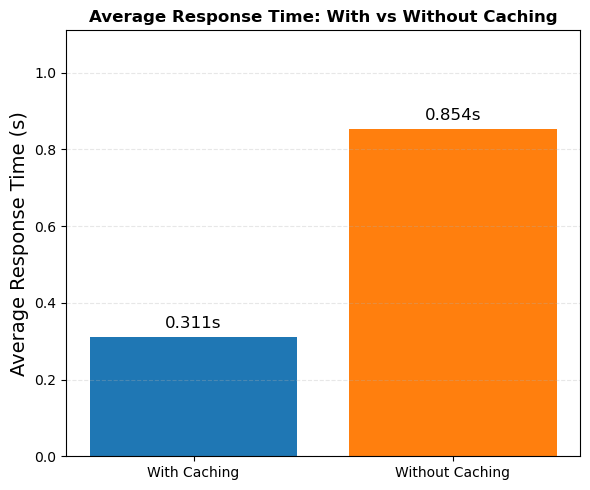

In [63]:
import matplotlib.pyplot as plt

# Data
labels = ['With Caching', 'Without Caching']
values = [0.311, 0.854]  # Avg response times in seconds

# Colors (colorblind-friendly)
colors = ['#1f77b4', '#ff7f0e']

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(labels, values, color=colors)

# Labels
ax.set_ylabel('Average Response Time (s)', fontsize=14)
ax.set_title('Average Response Time: With vs Without Caching', fontsize=12, fontweight='bold')
ax.set_ylim(0, max(values) * 1.3)  # extra space for annotations
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Annotate bars
for bar, val in zip(bars, values):
    ax.annotate(f"{val:.3f}s",
                xy=(bar.get_x() + bar.get_width() / 2, val),
                xytext=(0, 4),  # slight offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()

# Save high quality image
plt.savefig("avg_response_time_comparison.png", dpi=300, bbox_inches='tight')

plt.show()


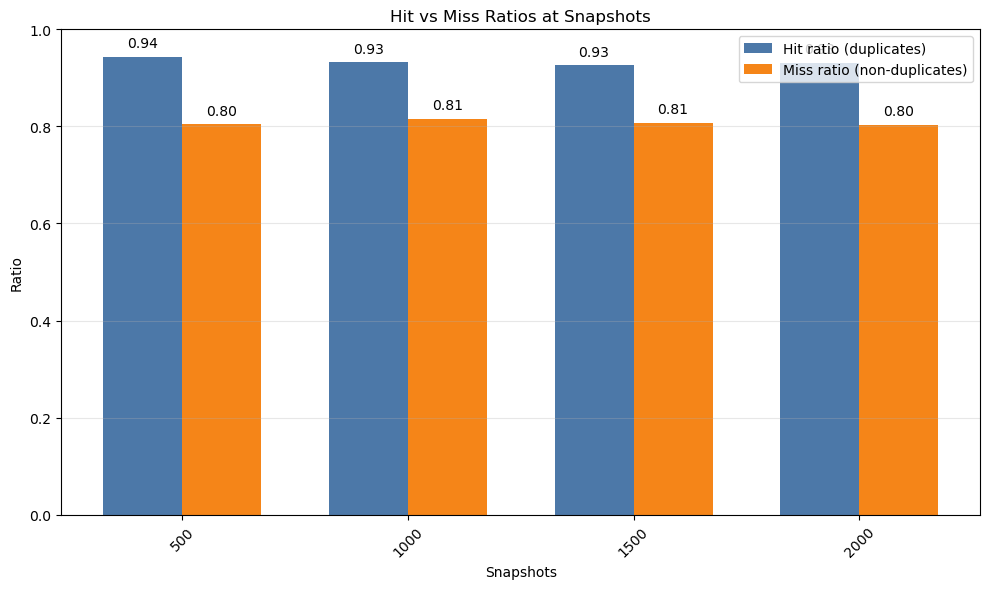

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Sample assumption: both dicts have the same snapshots
snapshots = results_dup["snapshots"]
hit_ratios = results_dup.get("hit_ratio", [])
miss_ratios = results_nondup.get("miss_ratio", [])

# Bar positions
x = np.arange(len(snapshots))  # snapshot indices
width = 0.35  # bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, hit_ratios, width, label='Hit ratio (duplicates)', color='#4c78a8')
plt.bar(x + width/2, miss_ratios, width, label='Miss ratio (non-duplicates)', color='#f58518')

# Labels and formatting
plt.xlabel('Snapshots')
plt.ylabel('Ratio')
plt.title('Hit vs Miss Ratios at Snapshots')
plt.xticks(x, snapshots, rotation=45)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for idx, val in enumerate(hit_ratios):
    plt.text(idx - width/2, val + 0.02, f"{val:.2f}", ha='center')
for idx, val in enumerate(miss_ratios):
    plt.text(idx + width/2, val + 0.02, f"{val:.2f}", ha='center')

plt.tight_layout()
plt.show()


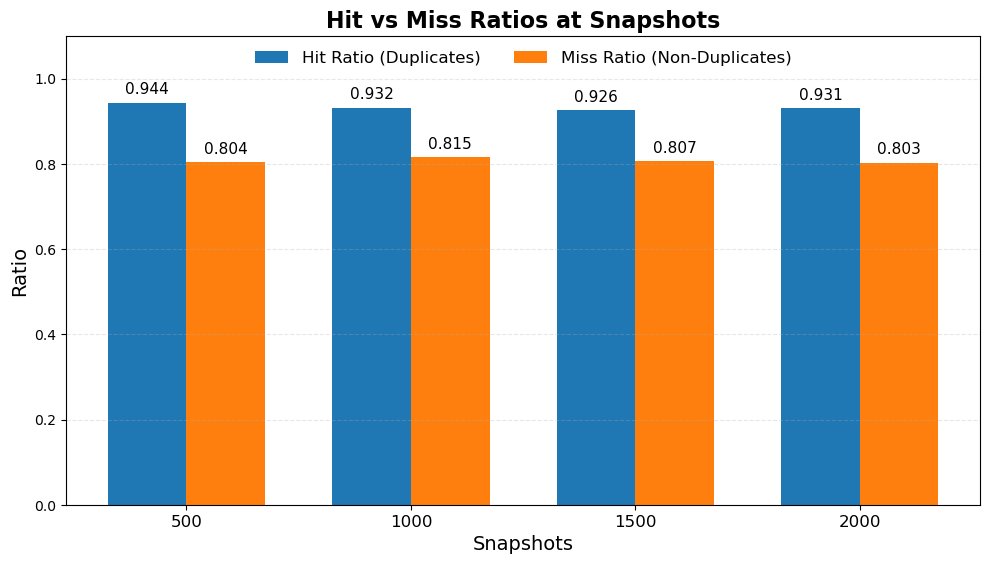

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Data
results_dup = {'snapshots': [500, 1000, 1500, 2000],
               'hit_ratio': [0.944, 0.932, 0.926, 0.9315]}
results_nondup = {'snapshots': [500, 1000, 1500, 2000],
                  'miss_ratio': [0.804, 0.815, 0.8066666666666666, 0.803]}

snapshots = results_dup["snapshots"]
hit_ratios = results_dup["hit_ratio"]
miss_ratios = results_nondup["miss_ratio"]

# Bar positions
x = np.arange(len(snapshots))
width = 0.35

# Colors
hit_color = '#1f77b4'   # blue
miss_color = '#ff7f0e'  # orange

fig, ax = plt.subplots(figsize=(10, 6))

# Bars
bars_hit = ax.bar(x - width/2, hit_ratios, width, label='Hit Ratio (Duplicates)', color=hit_color)
bars_miss = ax.bar(x + width/2, miss_ratios, width, label='Miss Ratio (Non-Duplicates)', color=miss_color)

# Labels & formatting
ax.set_xlabel('Snapshots', fontsize=14)
ax.set_ylabel('Ratio', fontsize=14)
ax.set_title('Hit vs Miss Ratios at Snapshots', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(snapshots, fontsize=12)
ax.set_ylim(0, 1.1)  # extra space for labels and legend
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Move legend completely outside the plot (below or above)
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, frameon=False)

# Annotate bars
def annotate(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11)

annotate(bars_hit)
annotate(bars_miss)

# Adjust layout to fit legend outside
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # extra space for legend at bottom

# Save high quality
plt.savefig("hit_vs_miss_ratios.png", dpi=300, bbox_inches='tight')

plt.show()


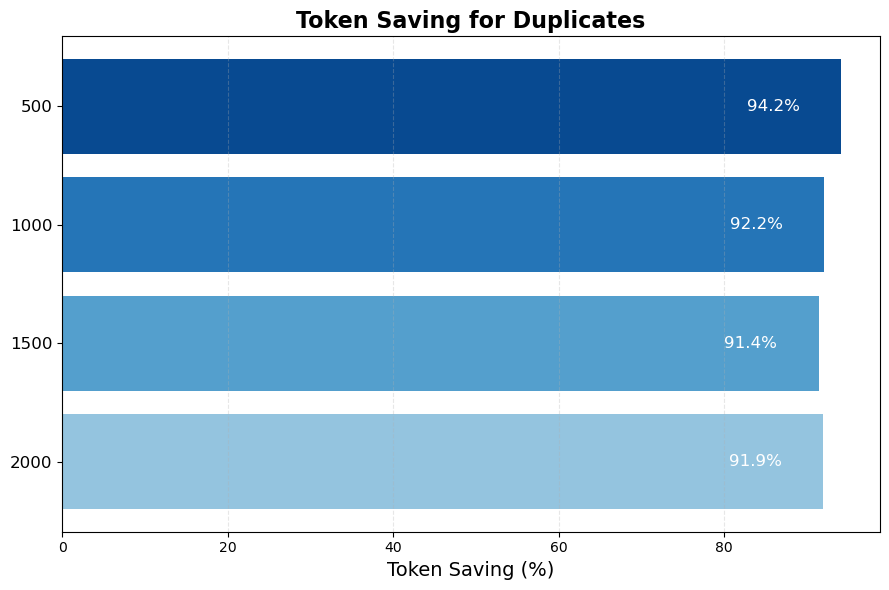

In [49]:
import matplotlib.pyplot as plt
import numpy as np

token_saving_dup = results_dup["token_saving_pct"]

# Sort values and snapshots together (if you want sorted)
sorted_data = sorted(zip(snapshots, token_saving_dup), key=lambda x: int(x[0]), reverse=True)
sorted_snapshots, sorted_savings = zip(*sorted_data)


# Create color gradient based on savings
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(sorted_savings)))

plt.figure(figsize=(9, 6))
bars = plt.barh(range(len(sorted_snapshots)), sorted_savings, color=colors)

plt.yticks(range(len(sorted_snapshots)), sorted_snapshots, fontsize=12)
plt.xlabel('Token Saving (%)', fontsize=14)
plt.title('Token Saving for Duplicates', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add labels inside bars
for i, (bar, val) in enumerate(zip(bars, sorted_savings)):
    plt.text(val - 5 if val > 10 else val + 1, bar.get_y() + bar.get_height()/2,
             f"{val:.1f}%", va='center', ha='right' if val > 10 else 'left', fontsize=12, color='white' if val > 10 else 'black')

plt.tight_layout()
plt.show()


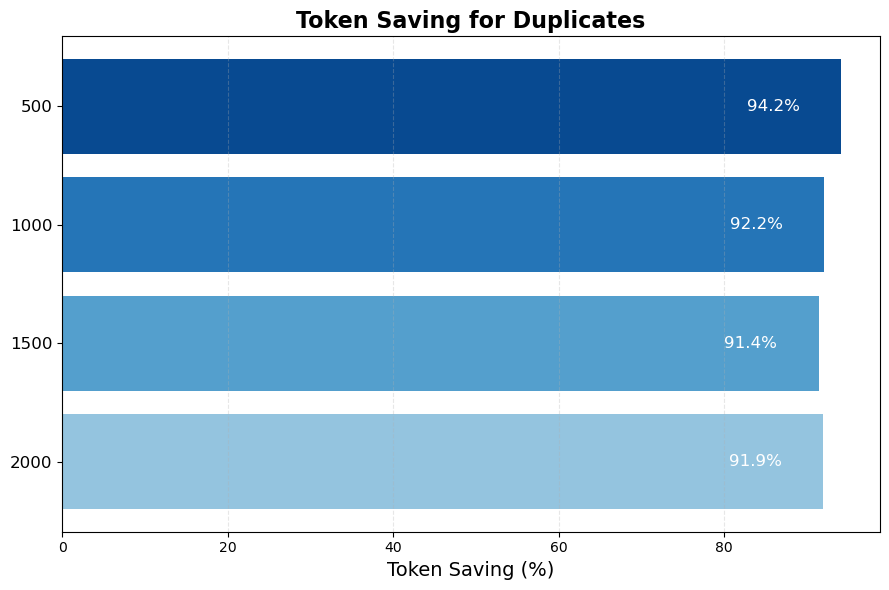

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual variables)
snapshots = ["500", "1000", "1500", "2000"]  # Replace with actual snapshot names
token_saving_dup = [94.15654252141007, 92.15028513921503, 91.4341311024039, 91.941982272361]

# Sort values and snapshots together
sorted_data = sorted(zip(snapshots, token_saving_dup), key=lambda x: int(x[0]), reverse=True)
sorted_snapshots, sorted_savings = zip(*sorted_data)

# Create color gradient based on savings
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(sorted_savings)))

# Plot
plt.figure(figsize=(9, 6))
bars = plt.barh(range(len(sorted_snapshots)), sorted_savings, color=colors)

# Y-axis labels
plt.yticks(range(len(sorted_snapshots)), sorted_snapshots, fontsize=12)
plt.xlabel('Token Saving (%)', fontsize=14)
plt.title('Token Saving for Duplicates', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add labels inside bars
for i, (bar, val) in enumerate(zip(bars, sorted_savings)):
    x_pos = val - 5 if val > 10 else val + 1
    color = 'white' if val > 10 else 'black'
    ha = 'right' if val > 10 else 'left'
    plt.text(x_pos, bar.get_y() + bar.get_height()/2,
             f"{val:.1f}%", va='center', ha=ha, fontsize=12, color=color)

plt.tight_layout()

# Save with high quality
plt.savefig("token_saving_duplicates.png", dpi=300, bbox_inches='tight')

plt.show()


In [47]:
# Evaluate LRU vs RL at cache size 500
policies = ['SEMANTIC_DECAY','LRU','LFU']
policy_hit_rates = {}
for p in policies:
    hit_rate = eval_hit_rate_for_policy(p, similar_pairs, cache_size=500, similarity_threshold=0.5)
    policy_hit_rates[p] = hit_rate
    print(f"Policy {p} hit rate: {hit_rate:.4f}")
policy_hit_rates


Initializing FAISS on CPU.
Enhanced Semantic Decay policy initialized
  decay_rate=0.01, boost_factor=0.7
  similarity_threshold=0.7
  age_weight=0.3, boost_weight=0.4
Eviction policy initialized: SEMANTIC_DECAY
Semantic Cache Manager initialized with SEMANTIC_DECAY eviction policy
Training stacking ensemble...
Fitting stacking ensemble...
Stacking ensemble training completed!
Cache cleared!
Policy SEMANTIC_DECAY hit rate: 0.5670
Initializing FAISS on CPU.
Eviction policy initialized: LRU
Semantic Cache Manager initialized with LRU eviction policy
Training stacking ensemble...
Fitting stacking ensemble...
Stacking ensemble training completed!
Cache cleared!


KeyboardInterrupt: 

In [ ]:
policies = ['LFU']
policy_hit_rates = {}
for p in policies:
    hit_rate = eval_hit_rate_for_policy(p, similar_pairs, cache_size=800, similarity_threshold=0.5)
    policy_hit_rates[p] = hit_rate
    print(f"Policy {p} hit rate: {hit_rate:.4f}")
policy_hit_rates

Initializing FAISS on CPU.
Eviction policy initialized: LFU
Semantic Cache Manager initialized with LFU eviction policy
Training stacking ensemble...
Fitting stacking ensemble...
Stacking ensemble training completed!
Cache cleared!
Policy LFU hit rate: 0.7450


{'LFU': 0.745}

In [ ]:
policies = ['LRU']
policy_hit_rates = {}
for p in policies:
    hit_rate = eval_hit_rate_for_policy(p, similar_pairs, cache_size=800, similarity_threshold=0.5)
    policy_hit_rates[p] = hit_rate
    print(f"Policy {p} hit rate: {hit_rate:.4f}")
policy_hit_rates

Initializing FAISS on CPU.
Eviction policy initialized: LRU
Semantic Cache Manager initialized with LRU eviction policy
Training stacking ensemble...
Fitting stacking ensemble...
Stacking ensemble training completed!
Cache cleared!
Policy LRU hit rate: 0.7930


{'LRU': 0.793}

In [ ]:
policies = ['SEMANTIC_DECAY']
policy_hit_rates = {}
for p in policies:
    hit_rate = eval_hit_rate_for_policy(p, similar_pairs, cache_size=800, similarity_threshold=0.5)
    policy_hit_rates[p] = hit_rate
    print(f"Policy {p} hit rate: {hit_rate:.4f}")
policy_hit_rates


Initializing FAISS on CPU.
Enhanced Semantic Decay policy initialized
  decay_rate=0.01, boost_factor=0.7
  similarity_threshold=0.7
  age_weight=0.3, boost_weight=0.4
Eviction policy initialized: SEMANTIC_DECAY
Semantic Cache Manager initialized with SEMANTIC_DECAY eviction policy
Training stacking ensemble...
Fitting stacking ensemble...
Stacking ensemble training completed!
Cache cleared!
Evicting (score=0.330, fresh=1.398, age=0.2h, boosts=0): Can the sending end current be smaller than receiv...
Evicting (score=0.330, fresh=1.398, age=0.2h, boosts=0): How can new world order be stopped?...
Evicting (score=0.330, fresh=1.398, age=0.2h, boosts=0): Is Ravana's golden lanka still in Sri Lanka?...
Policy SEMANTIC_DECAY hit rate: 0.7970


{'SEMANTIC_DECAY': 0.797}

In [ ]:
policies = ['SEMANTIC_DECAY','LRU','LFU']
policy_hit_rates = {}
for p in policies:
    hit_rate = eval_hit_rate_for_policy(p, similar_pairs, cache_size=300, similarity_threshold=0.5)
    policy_hit_rates[p] = hit_rate
    print(f"Policy {p} hit rate: {hit_rate:.4f}")
policy_hit_rates


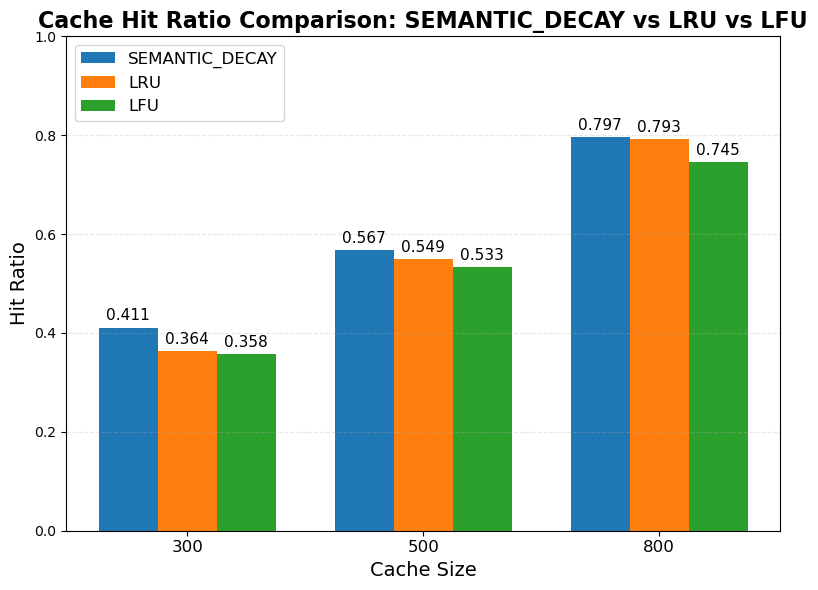

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each cache size
data = {
    300: {'SEMANTIC_DECAY': 0.4110, 'LRU': 0.364, 'LFU': 0.358},
    500: {'SEMANTIC_DECAY': 0.5670, 'LRU': 0.549, 'LFU': 0.533},
    800: {'SEMANTIC_DECAY': 0.797, 'LRU': 0.793, 'LFU':0.745 }
}

cache_sizes = list(data.keys())
policies = ['SEMANTIC_DECAY', 'LRU', 'LFU']

# Prepare values
values = [[data[size][policy] for policy in policies] for size in cache_sizes]

# Bar chart settings
x = np.arange(len(cache_sizes))  # positions for cache sizes
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(8, 6))

# Use a modern color palette (colorblind friendly)
colors = {
    'SEMANTIC_DECAY': '#1f77b4',   # blue
    'LRU': '#ff7f0e',  # orange
    'LFU': '#2ca02c'   # green
}

# Plot each policy
bars_rl = ax.bar(x - width, [v[0] for v in values], width, label='SEMANTIC_DECAY', color=colors['SEMANTIC_DECAY'])
bars_lru = ax.bar(x, [v[1] for v in values], width, label='LRU', color=colors['LRU'])
bars_lfu = ax.bar(x + width, [v[2] for v in values], width, label='LFU', color=colors['LFU'])

# Labels and formatting
ax.set_ylabel('Hit Ratio', fontsize=14)
ax.set_xlabel('Cache Size', fontsize=14)
ax.set_title('Cache Hit Ratio Comparison: SEMANTIC_DECAY vs LRU vs LFU', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(cache_sizes, fontsize=12)
ax.set_ylim(0, 1.0)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Annotate bars with values
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11)

annotate_bars(bars_rl)
annotate_bars(bars_lru)
annotate_bars(bars_lfu)

plt.tight_layout()

# Save as high-quality image
plt.savefig("cache_hit_ratio_comparison.png", dpi=300, bbox_inches='tight')

plt.show()
